# Предсказание удержания клиентов интернет-магазина

Необходимо выбрать наилучшую модель для предсказания вероятности снижения покупательсткой активности.

## Цель
С помощью модели необходимо повысить покупательсткую активность различных категорий клиентов
 - выбрать и обучить модель, наилучшим образом предсказывающую покеупательскую способность пользоываелей;
 - выделить сегменты клиентов с учётом выручки бизнеса, покупательской способности и других характеристик пользователей;
 - разработать для каждого выделенного сегмента клиентов стратегии, повышаюшие удержание

## Описание данных:
### Поведение покупателя
- `id` — уникальный идентификатор покупателя в корпоративной базе данных.
- `Покупательская активность` — целевой признак, показывающий класс покупательской активности: «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса («премиум» или «стандарт»), зависящий от наличия подписки.
- `Разрешить сообщать` — бинарный признак (да, нет), указывающий, можно ли присылать клиенту дополнительные предложения.
- `Маркет_актив_6_мес` — среднемесячное количество маркетинговых коммуникаций за последние 6 месяцев (рассылки, звонки, реклама).
- `Маркет_актив_тек_мес` — число маркетинговых коммуникаций в текущем месяце.
- `Длительность` — количество дней с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от всех покупок за последние 6 месяцев.
- `Популярная_категория` — наиболее часто покупаемая категория товаров за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — среднее число категорий, просмотренных за один визит за последний месяц.
- `Неоплаченные_продукты_штук_квартал` — количество неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев сервиса, затронувших клиента за последние 3 месяца.
- `Страниц_за_визит` — среднее количество страниц, просмотренных клиентом за визит за последние 3 месяца.
### Выручка от покупателя
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- `Выручка` — сумма выручки за период в условных единицах.
### Время, проведённое покупателем на сайте
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.
### Прибыль от покупателя
- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли в условных единицах.

## План исследования

1) Предобработка данных
2) Исследовательский анализ данных
3) Подготовка данных к ML
4) Корреляционный анализ
5) Построение пайплайнов для выбора лучшей модели
6) Анализ важности признаков
7) Сегментация покупателей
8) Общий вывод

##  Предобработка данных

### Импорт модулей

In [1]:
! pip install shap
! pip install phik

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import shap
import random
import phik
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

Определение констант

In [3]:
RANDOM_STATE = 1
TEST_SIZE = 0.2

In [4]:
try:
    market = pd.read_csv(r".\source\market_file.csv", sep = ',')
    market_revenue = pd.read_csv(r".\source\market_money.csv", sep = ',')
    market_time = pd.read_csv(r".\source\market_time.csv", sep = ',')
    profit = pd.read_csv(r".\source\money.csv", sep = ';', decimal = ',')
except:
    market = pd.read_csv(r"/datasets/market_file.csv", sep = ',')
    market_revenue = pd.read_csv(r"/datasets/market_money.csv", sep = ',')
    market_time = pd.read_csv(r"/datasets/market_time.csv", sep = ',')
    profit = pd.read_csv(r"/datasets/money.csv", sep = ';', decimal = ',')

pd.set_option('display.max_columns', None)
display(market.head(20))
display(market_revenue.head(20))
display(market_time.head(20))
display(profit.head(20))

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
6,215354,3.62
7,215355,5.26
8,215356,4.93
9,215357,4.66


### Переименуем называния колонок в соостветствии с конвенциональным наименованием

In [5]:
market = market.rename(columns = {"id": "id",
                                    "Покупательская активность": "покупательская_активность",
                                    "Тип сервиса": "тип_сервиса",
                                    "Разрешить сообщать": "разрешить_сообщать",
                                    "Маркет_актив_6_мес": "маркет_актив_6_мес",
                                    "Маркет_актив_тек_мес": "маркет_актив_тек_мес",
                                    "Длительность": "длительность",
                                    "Акционные_покупки": "акционные_покупки",
                                    "Популярная_категория": "популярная_категория",
                                    "Средний_просмотр_категорий_за_визит": "средний_просмотр_категорий_за_визит",
                                    "Неоплаченные_продукты_штук_квартал": "неоплаченные_продукты_штук_квартал",
                                    "Ошибка_сервиса": "ошибка_сервиса",
                                    "Страниц_за_визит": "страниц_за_визит"})
market_revenue = market_revenue.rename(columns = {"id": "id",
                                    "Период": "период",
                                    "Выручка": "выручка"})
market_time = market_time.rename(columns = {"id": "id",
                                        "Период": "период",
                                        "минут": "минут"})
profit = profit.rename(columns = {"id": "id",
                                "Прибыль": "прибыль"})

In [6]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [7]:
market_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [8]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [9]:
profit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


### Проверим наличие явных дубликатов

In [10]:
def handle_duplicates(dataframe):
    duplicates_count = dataframe.duplicated().sum()

    if duplicates_count > 0:
        dataframe.drop_duplicates(inplace = True)
    
    display(f"Droped {duplicates_count} duplicates.")

In [11]:
handle_duplicates(market)
handle_duplicates(market_revenue)
handle_duplicates(market_time)
handle_duplicates(profit)

'Droped 0 duplicates.'

'Droped 0 duplicates.'

'Droped 0 duplicates.'

'Droped 0 duplicates.'

### Преобразуем данные к соответствующим типам

In [12]:
float_columns = ["прибыль"]
display(profit.info())
display([c.encode("unicode_escape") for c in profit.columns])
display("прибыль" == profit.columns[1])
profit = profit.astype({"прибыль": "float"})
market_time = market_time.astype({"период": "category"})
market_revenue = market_revenue.astype({"период": "category"})
market = market.astype({"покупательская_активность": "category",
                        "тип_сервиса": "category",
                        "популярная_категория": "category"})

market["разрешить_сообщать"] = pd.Series([allow == "да" for allow in market["разрешить_сообщать"]], dtype = "boolean")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

[b'id', b'\\u043f\\u0440\\u0438\\u0431\\u044b\\u043b\\u044c']

True

In [13]:
market.head(1)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,True,3.4,5,121,0.0,Товары для детей,6,2,1,5


In [14]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   1300 non-null   int64   
 1   покупательская_активность            1300 non-null   category
 2   тип_сервиса                          1300 non-null   category
 3   разрешить_сообщать                   1300 non-null   boolean 
 4   маркет_актив_6_мес                   1300 non-null   float64 
 5   маркет_актив_тек_мес                 1300 non-null   int64   
 6   длительность                         1300 non-null   int64   
 7   акционные_покупки                    1300 non-null   float64 
 8   популярная_категория                 1300 non-null   category
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64   
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64   
 11  ошибка_сервиса   

In [15]:
market.nunique()

id                                     1300
покупательская_активность                 2
тип_сервиса                               3
разрешить_сообщать                        2
маркет_актив_6_мес                       41
маркет_актив_тек_мес                      3
длительность                            658
акционные_покупки                        42
популярная_категория                      6
средний_просмотр_категорий_за_визит       6
неоплаченные_продукты_штук_квартал       11
ошибка_сервиса                           10
страниц_за_визит                         20
dtype: int64

In [16]:
market_revenue.head(1)

,id,период,выручка
0,215348,препредыдущий_месяц,0.0


In [17]:
market_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   id       3900 non-null   int64   
 1   период   3900 non-null   category
 2   выручка  3900 non-null   float64 
dtypes: category(1), float64(1), int64(1)
memory usage: 65.0 KB


In [18]:
market_revenue.nunique()

id         1300
период        3
выручка    2776
dtype: int64

In [19]:
market_time.head(1)

,id,период,минут
0,215348,текущий_месяц,14


In [20]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   id      2600 non-null   int64   
 1   период  2600 non-null   category
 2   минут   2600 non-null   int64   
dtypes: category(1), int64(2)
memory usage: 43.4 KB


In [21]:
market_time.nunique()

id        1300
период       2
минут       20
dtype: int64

In [22]:
profit.head(1)

,id,прибыль
0,215348,0.98


Заметим, что значение прибыли на 3 порядка ниже выручки, что кажется подозрительным

In [23]:
profit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [24]:
profit.nunique()

id         1300
прибыль     400
dtype: int64

### Проверим наличие пропусков в данных

In [25]:
market.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

In [26]:
market_revenue.isna().sum()

id         0
период     0
выручка    0
dtype: int64

In [27]:
market_time.isna().sum()

id        0
период    0
минут     0
dtype: int64

In [28]:
profit.isna().sum()

id         0
прибыль    0
dtype: int64

### Исправим описки в данных

In [29]:
market["тип_сервиса"] = market["тип_сервиса"].replace({"стандартт": "стандарт"})
market_time["период"] = market_time["период"].replace({"предыдцщий_месяц": "предыдущий_месяц"})
market_revenue["период"] = market_revenue["период"].replace({"препредыдущий_месяц": "препредыдущий_месяц"})

In [30]:
market_revenue.values

array([[215348, 'препредыдущий_месяц', 0.0],
       [215348, 'текущий_месяц', 3293.1],
       [215348, 'предыдущий_месяц', 0.0],
       ...,
       [216647, 'предыдущий_месяц', 4720.0],
       [216647, 'препредыдущий_месяц', 5183.0],
       [216647, 'текущий_месяц', 4448.3]], dtype=object)

Были получены и подготовлены 4 файла с данными:
- унификация называний признаков
- фильтрация дубликатов
- преобразования типов данных
- обработаны пропуски
- исправлены описки

## Исследовательский анализ данных

### Рассмотрим описательную статистику данных

In [31]:
market.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Большинство пользователей пользуяются сайтом более 3 месяцев, что хорошо для целей исследования. Остальная статистика выглядит адекватно и не вызывает вопросов.

In [32]:
market_revenue.describe()

,id,выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


Пользователь, принёсший компании наибольшую выручку потратил примерно в 20 раз больше, чем тратят обычно. Стоит держать во внимании, что это можно воспринимать как аномалию. Удалим её из данных.

In [33]:
market_revenue = market_revenue[(market_revenue["выручка"] < 10000) & (market_revenue["выручка"] > 0)]

In [34]:
market_time.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


Значения времени, проведённого пользователями на сайте выглядит адекватно и не вызывает вопросов.

In [35]:
profit.describe()

,id,прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


Значения прриьыли выражены в условных единицах, как и значения выручки от пользователей. Однако, они на 3 порядка меньше, чем значения выручки. Делаем вывод, что это ошибка т.к. при таких значениях маржинальности бизнес не мог бы существовать. Поэтому исправим значения увеличив их на 3 порядка.

In [36]:
profit["масштабированная_прибыль"] = profit["прибыль"] * 1000

### Далее построим графики частот для количественных признаков.

Для анализа выберем клиентов с покупательской активностью не менее трёх месяцев

In [37]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   1300 non-null   int64   
 1   покупательская_активность            1300 non-null   category
 2   тип_сервиса                          1300 non-null   category
 3   разрешить_сообщать                   1300 non-null   boolean 
 4   маркет_актив_6_мес                   1300 non-null   float64 
 5   маркет_актив_тек_мес                 1300 non-null   int64   
 6   длительность                         1300 non-null   int64   
 7   акционные_покупки                    1300 non-null   float64 
 8   популярная_категория                 1300 non-null   category
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64   
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64   
 11  ошибка_сервиса   

In [38]:
market_with_profit = pd.merge(market, profit, on = "id")
market_with_profit_and_revenue = pd.merge(market_with_profit, market_revenue, on = "id")
filtered = market_with_profit_and_revenue.groupby("id").filter(lambda x: x["выручка"].all())["id"].unique()
market = market[market["id"].isin(filtered)]

In [39]:
market.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   1300 non-null   int64   
 1   покупательская_активность            1300 non-null   category
 2   тип_сервиса                          1300 non-null   category
 3   разрешить_сообщать                   1300 non-null   boolean 
 4   маркет_актив_6_мес                   1300 non-null   float64 
 5   маркет_актив_тек_мес                 1300 non-null   int64   
 6   длительность                         1300 non-null   int64   
 7   акционные_покупки                    1300 non-null   float64 
 8   популярная_категория                 1300 non-null   category
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64   
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64   
 11  ошибка_сервиса   

Все пользователи из начального набора данных оказались активными за последние три месяца

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


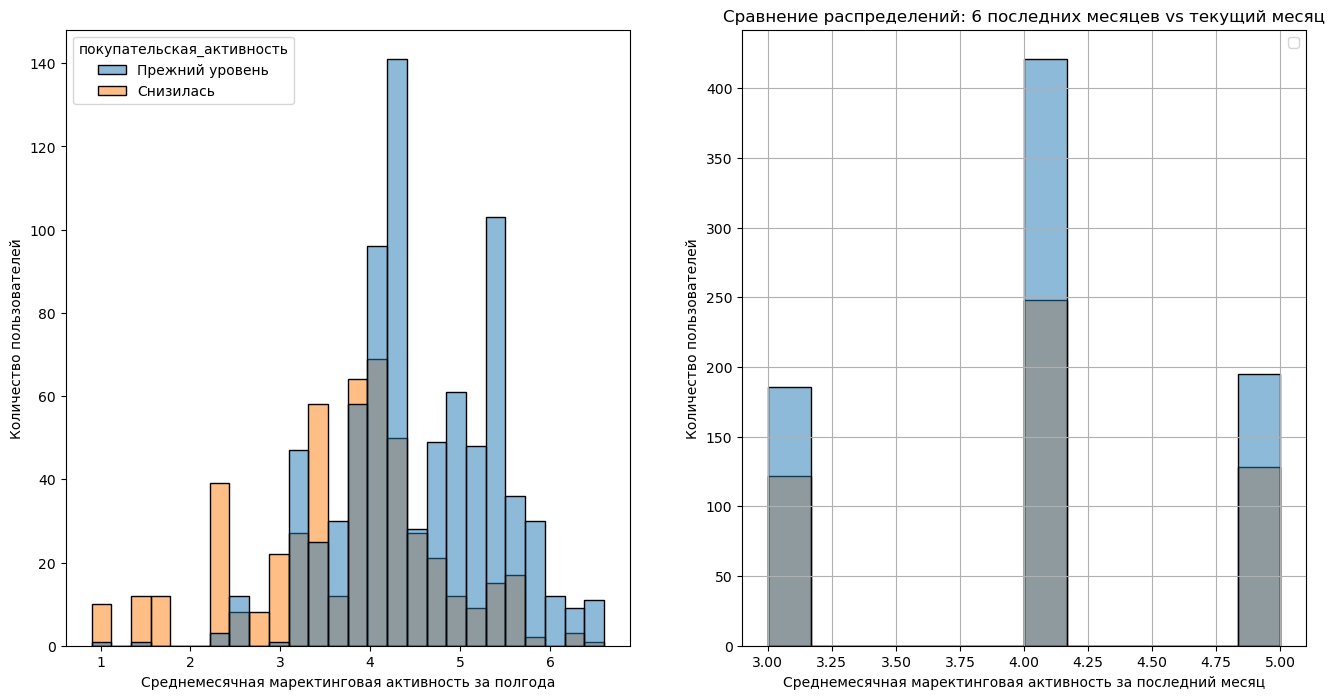

In [40]:
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (16, 8))

sns.histplot(market, x = "маркет_актив_6_мес", bins = "auto", alpha = 0.5, color = "blue", hue = "покупательская_активность", ax = axs[0])
sns.histplot(market, x = "маркет_актив_тек_мес", bins = "auto", alpha = 0.5, color = "orange", hue = "покупательская_активность", ax = axs[1])
axs[0].set_xlabel("Среднемесячная маректинговая активность за полгода")
axs[0].set_ylabel("Количество пользователей")
axs[1].set_xlabel("Среднемесячная маректинговая активность за последний месяц")
axs[1].set_ylabel("Количество пользователей")
plt.title("Сравнение распределений: 6 последних месяцев vs текущий месяц")
plt.legend()
plt.grid(True)

plt.show()

Частота маркетинговой активности мультимодальна с модой 4 и локальной модой в 5.5 коммуницаций в месяц. Так же заметны значения близкие к выбросам до 2 коммуникаций в месяц. Заметим, что покупательская **активность остаётся на прежднем уровне** во многом у пользователей, которые взаимодействуют **более чем с 5 маркетинговыми активностями в месяц**. При этом так же заметно, что большая часть пользвателей со **сниженным уровнем активности** взаимодействуют с **менее чем 4 маркетинговыми активностями в месяц**.

Создадим унифицированную функцию отображения признаков с выделение покупательской активности цветом.

In [41]:
COLOR_PAIRS = [
    ["#1f77b4", "#ff7f0e"],
    ["#2ca02c", "#d62728"],
    ["#17becf", "#bcbd22"],
    ["#0d6efd", "#fd7e14"],
]

def plot_distribution(df, column, xlabel, title, discrete = False, palette = None):
    fig, ax = plt.subplots(figsize = (10, 6))

    if discrete:
        bins = range(df[column].min(), df[column].max() + 1)
        multiple = "dodge"
        shrink = 0.8
    else:
        bins = 30
        multiple = "layer"
        shrink = 1.0

    if palette is None:
        palette = random.choice(COLOR_PAIRS)

    sns.histplot(df, 
                 x = column, 
                 bins = bins, 
                 hue = "покупательская_активность", 
                 multiple = multiple, 
                 shrink = shrink, 
                 alpha = 0.5, 
                 palette = palette, 
                 ax = ax)

    ax.set_xlabel(xlabel)
    ax.set_ylabel("Количество пользователей")
    ax.set_title(title)
    ax.grid(True)

    plt.show()

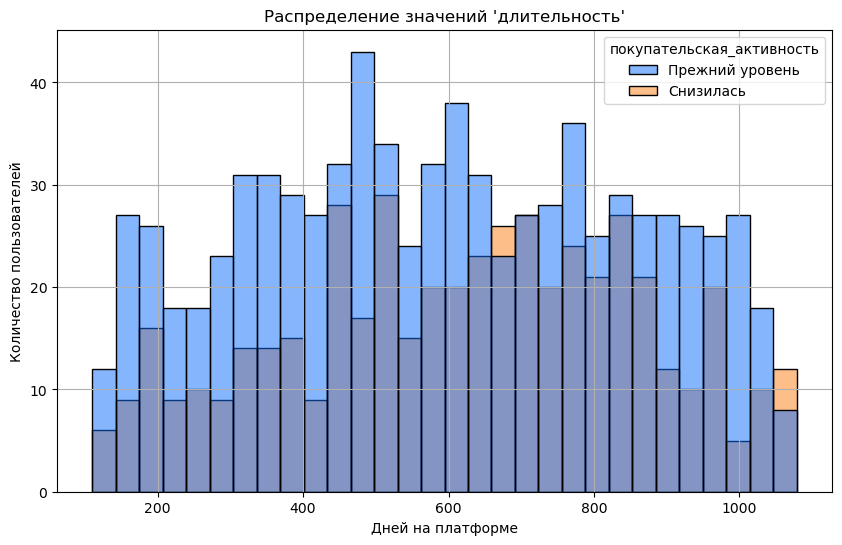

In [42]:
plot_distribution(market, "длительность", "Дней на платформе", "Распределение значений 'длительность'")


Длительность пребывания пользователей на платформе распределена схоже с нормальным распеределением без явных выбросов и аномалий. Заметно, что больше всегшо **вероятность снижения покупательской активности** у пользователей, которые **зарегистрировались на платформе примерно от 7 до 14 месяцев назад**.

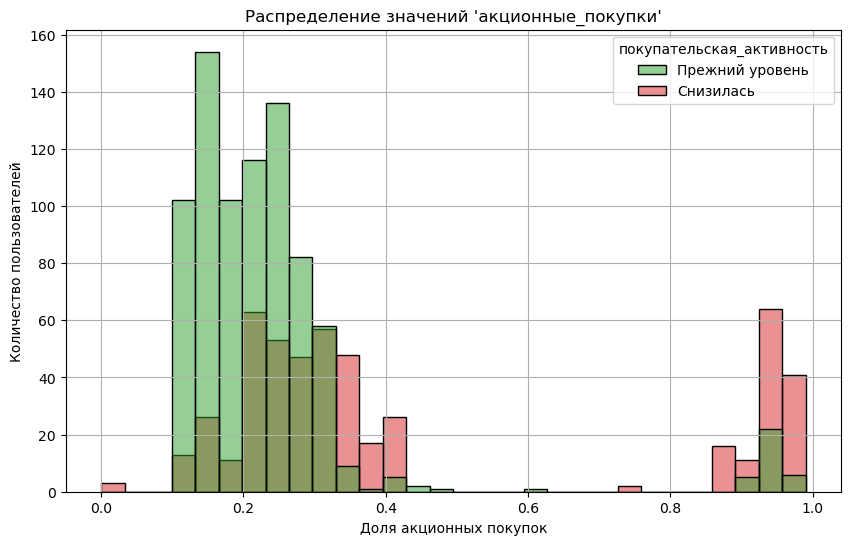

In [43]:
plot_distribution(market, "акционные_покупки", "Доля акционных покупок", "Распределение значений 'акционные_покупки'")


Доля акционных покупок распределена мультимодельно. Большинство пользователей покупает лишь треть покупок по акции. Но так же видно меньшее, но значимое, количество пользователей, которые стремятся покупать все товары по акции. Можно сделать однозначный вывод, что пользователи, **покупающие по акции более 35%** покупок с высокой вероятностью **снизят** свою покупательскую **активность** в будущем т.к. таких пользователей меньшенство, но вторая мода в распределении более чем на половину состоит из тких пользователей.

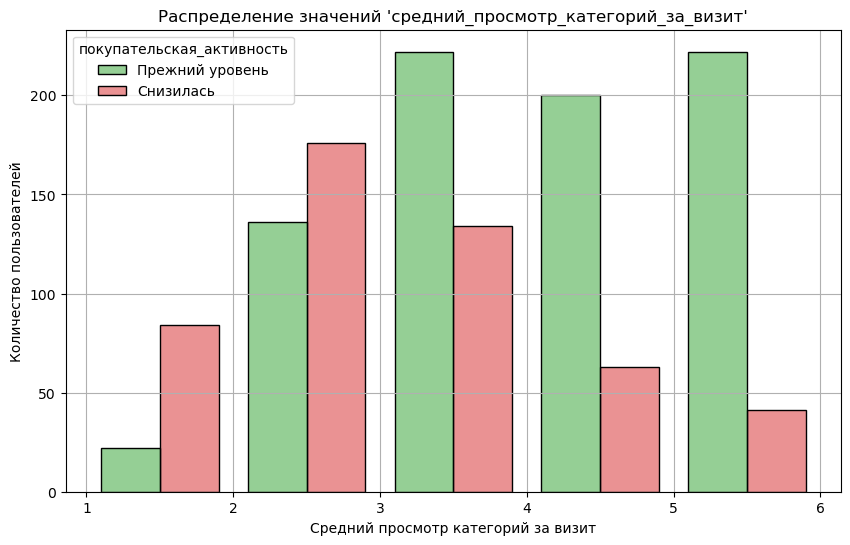

In [44]:
plot_distribution(market, "средний_просмотр_категорий_за_визит", "Средний просмотр категорий за визит", "Распределение значений 'средний_просмотр_категорий_за_визит'", discrete = True)

Большинство пользователей просматривает от 2 до 5 категорий за визит. При этом явно заметно, что если пользователь **просматривает за раз менее 2 категорий**, у него повышенный риск **снижения активности**.

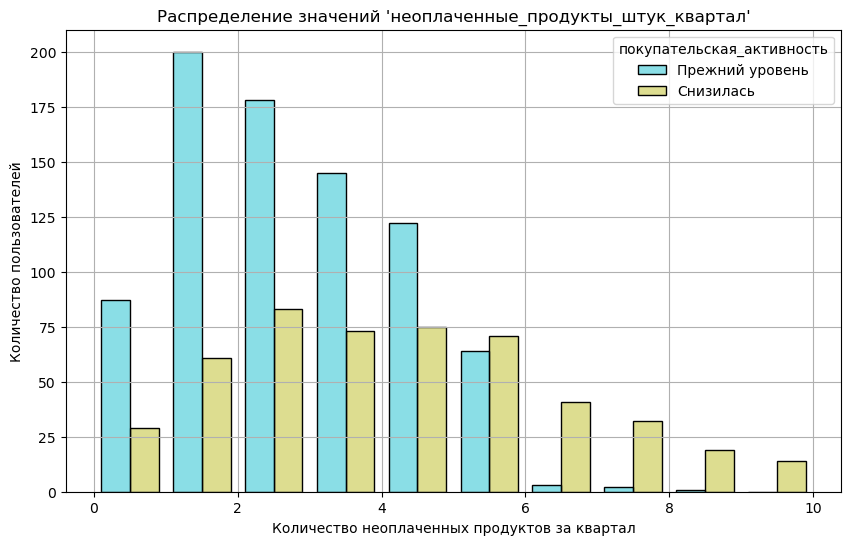

In [45]:
plot_distribution(market, "неоплаченные_продукты_штук_квартал", "Количество неоплаченных продуктов за квартал", "Распределение значений 'неоплаченные_продукты_штук_квартал'", discrete = True)

Распределение количества оставленных в корзине без покупки товаров напоминает распределение Пуассона. Чаще всего пользователи оставляют около 2 таваров в корзине в течение 3 месяцев неоплеченными. При том для клиентов со сниженным уровнем активности распределение имеет большую дисперсию и моду. Так, если у пользователя **в корзине более 4 неоплаченных товаров за последние 3 месяца**, то повышается риск **снижения его активности**. 

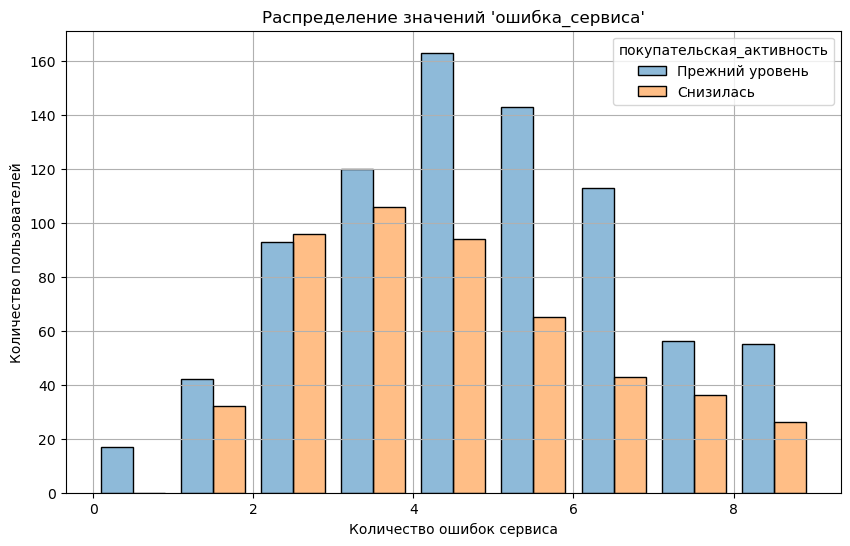

In [46]:
plot_distribution(market, "ошибка_сервиса", "Количество ошибок сервиса", "Распределение значений 'ошибка_сервиса'", discrete = True)

Количество ошибок сервиса, с которыми сталкиваются пользователи в течение квартала при посещении сайта распределно нормально со средним значением в 4 ошибки за 3 месяца. При этом у пользователей снижается покупательская активность если они сталкиваются с 2 или 3 ошибками в квартал. Если ошибок 1 или более 4, это мало влияет на покупательскую активность, что странно. В целом количество ошибок вряд ли можно достоверно использовать как предиктор поукпательской активности.

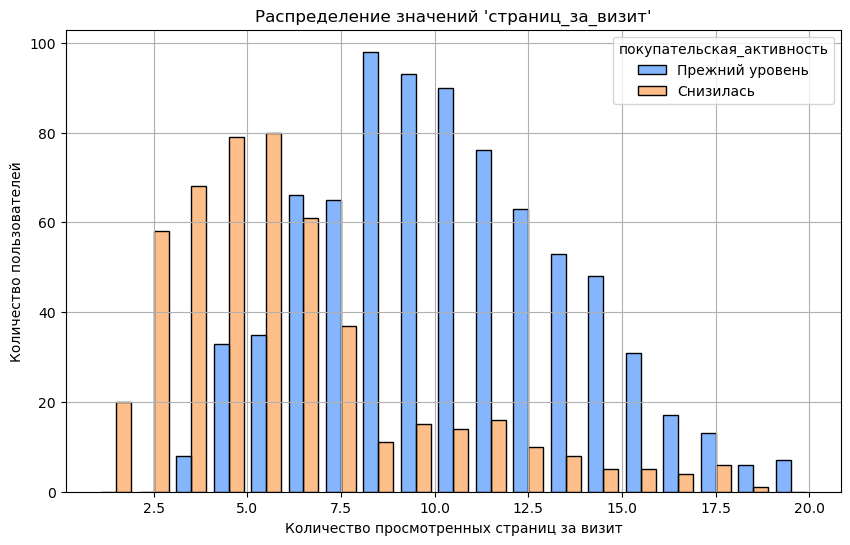

In [47]:
plot_distribution(market, "страниц_за_визит", "Количество просмотренных страниц за визит", "Распределение значений 'страниц_за_визит'", discrete = True)

Количество просмотренных пользователями с пониженной покупательской активностью страниц за визит в сервис распределно схоже с распределенгием Пуассона. При этом пользователи со стабильной пок3упательской активностью просматривают в мреднем больше страниц за визит и количество страниц распределно ближе к нормальному для стабильных пользователей. Если пользователь **в среднем** просматривает **менее 8 страниз за визит** в течение месяца, у него повышенный риск **снижения активности**.

Т.к. доступны значения выручки для последних 3 месяцев, построим 3 графика и подробно рассмотрим изменения для групп пользователей по целевому признаку.

In [48]:
market_revenue = pd.pivot_table(market_revenue, values = "выручка", index = "id", columns = "период", aggfunc = "sum")
market_revenue.columns = ["предыдущий_месяц_выручка", "препредыдущий_месяц_выручка", "текущий_месяц_выручка"]
market_revenue.reset_index(inplace = True)
merged_revenue = pd.merge(market, market_revenue, on = "id", how = "inner")

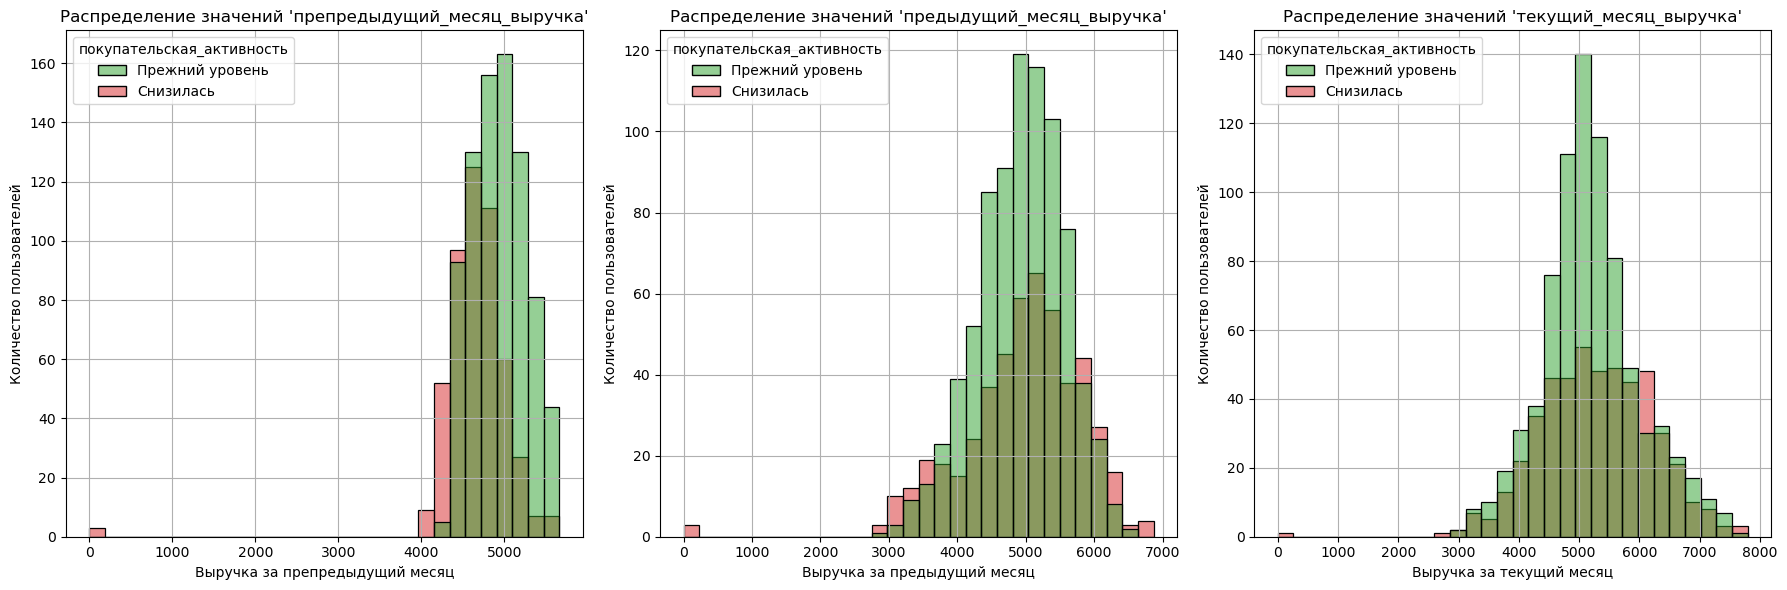

In [49]:
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (18, 6))

features = [
    ("препредыдущий_месяц_выручка", "Выручка за препредыдущий месяц"),
    ("предыдущий_месяц_выручка", "Выручка за предыдущий месяц"),
    ("текущий_месяц_выручка", "Выручка за текущий месяц"),
]

color_palette = random.choice(COLOR_PAIRS)

for ax, (col, xlabel) in zip(axs, features):
    sns.histplot(merged_revenue, 
                 x = col, 
                 bins = 30, 
                 hue = "покупательская_активность", 
                 alpha = 0.5, 
                 palette = color_palette, 
                 ax = ax)

    ax.set_xlabel(xlabel)
    ax.set_ylabel("Количество пользователей")
    ax.set_title(f"Распределение значений '{col}'")
    ax.grid(True)

plt.tight_layout()
plt.show()


Заметно, что при **выручке от клиента менее 4800 у.е. двумя месяцами ранее** повышается вероятносит **снижения покупательской активности** клиента в будущем. Распределения выручки от пользователей разных целевых категорий за текущий и предыдущий месяца при этом схожи и напоминают нормальное распределение.

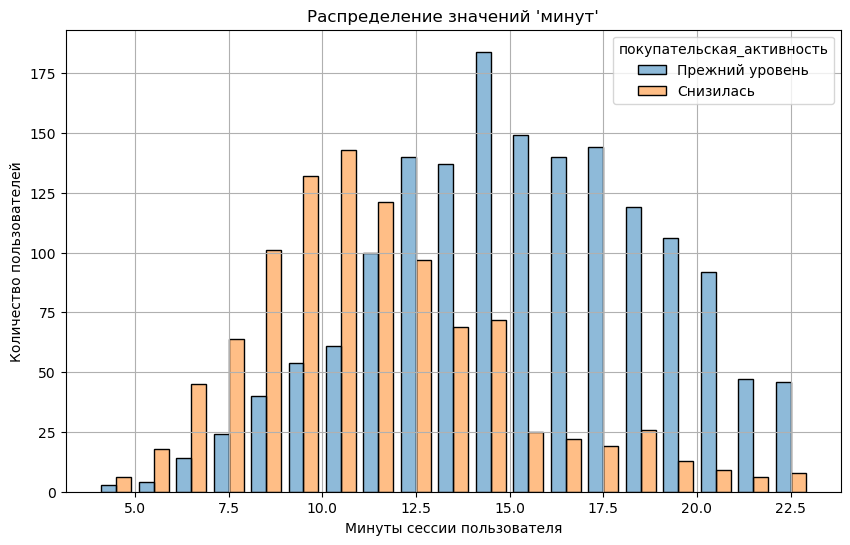

In [50]:
merged_time = pd.merge(market, market_time, on = "id", how = "inner")

plot_distribution(merged_time, "минут", "Минуты сессии пользователя", "Распределение значений 'минут'", discrete = True)

Минуты стабильных клиентов распределены схоже с нормальным распределением со средним в примерно 15 минут проведённых в сервисе за одну сессию. Для клиентов с понижающейся активностью распределение больше напоминает Пуассона и вероятность **понижения покупательской активности** возрастает при значениях **ниже 12 минут за сессию**. 

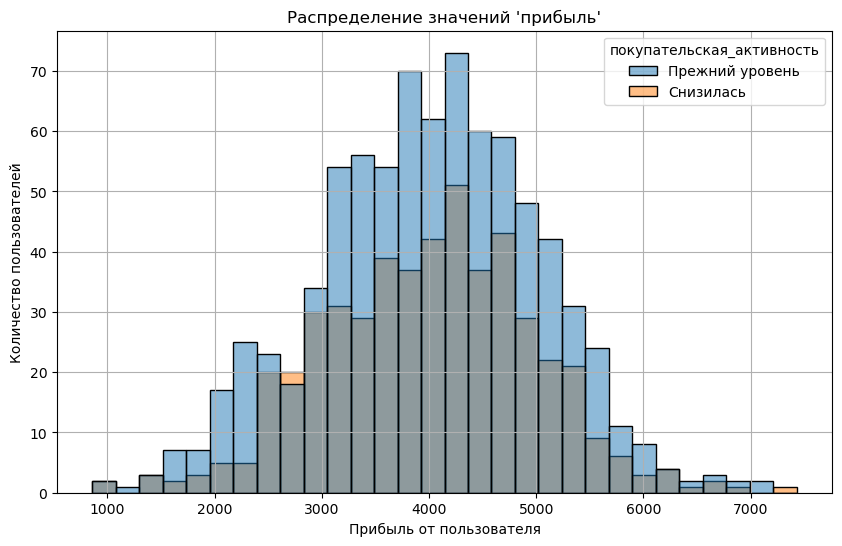

In [51]:
merged_profit = pd.merge(market, profit, on = "id", how = "inner")

plot_distribution(merged_profit, "масштабированная_прибыль", "Прибыль от пользователя", "Распределение значений 'прибыль'")

Прибыль распределена схоже с нормальным распределением со средним значением около 4000 у.е. и является плохим предиктором покупательской активности.

### Рассмотрим частоты распределения качестыенных характеристик

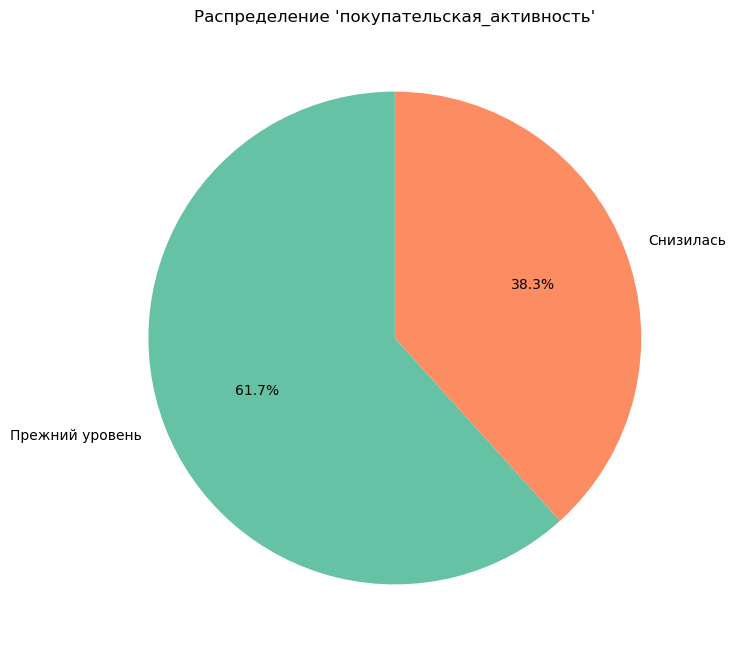

In [52]:
activity_counts = market["покупательская_активность"].value_counts()

plt.figure(figsize = (8, 8))
plt.pie(activity_counts, 
        labels = activity_counts.index, 
        autopct = "%1.1f%%", 
        startangle = 90, 
        colors = plt.cm.Set2.colors)

plt.title("Распределение 'покупательская_активность'")
plt.show()

Примерно у трети пользователей целевой признак покупательской активности снизился в последнее время

In [53]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.colors import to_hex

def plot_categorical_pie(df, category_col, target_col = "покупательская_активность", title = None):
    grouped = df.groupby([category_col, target_col]).size().reset_index(name = "count")
    outer = grouped.groupby(category_col)["count"].sum()
    inner = grouped["count"]
    target_order = ["Снизилась", "Прежний уровень"]
    color_map = {"Снизилась": "#d62728", "Прежний уровень": "#2ca02c"}  # красный / зелёный
    grouped[target_col] = pd.Categorical(grouped[target_col], categories = target_order, ordered = True)
    grouped = grouped.sort_values([category_col, target_col])
    inner_colors = grouped[target_col].map(color_map)
    base_colors = [to_hex(c) for c in plt.cm.Set3.colors]
    forbidden = {"#d62728", "#2ca02c"}
    outer_colors = [c for c in base_colors if c.lower() not in forbidden]
    fig, ax = plt.subplots(figsize = (10, 10))

    ax.pie(outer,
           labels = outer.index,
           radius = 1,
           startangle = 90,
           wedgeprops = dict(width = 0.3, edgecolor = "w"),
           colors = outer_colors[:len(outer)])  # берём столько, сколько категорий

    ax.pie(grouped["count"],
           radius = 0.7,
           startangle = 90,
           labels = None,
           autopct = None,
           wedgeprops = dict(width = 0.3, edgecolor = "w"),
           colors = inner_colors)

    legend_handles = [Patch(facecolor = color_map[val], edgecolor = "w", label = val) for val in target_order]
    ax.legend(handles = legend_handles, title = target_col, loc = "upper right", bbox_to_anchor = (1.2, 1))
    ax.set(aspect = "equal")

    if title is None:
        title = f"Распределение '{category_col}' с долями '{target_col}'"
        
    plt.title(title)
    plt.show()


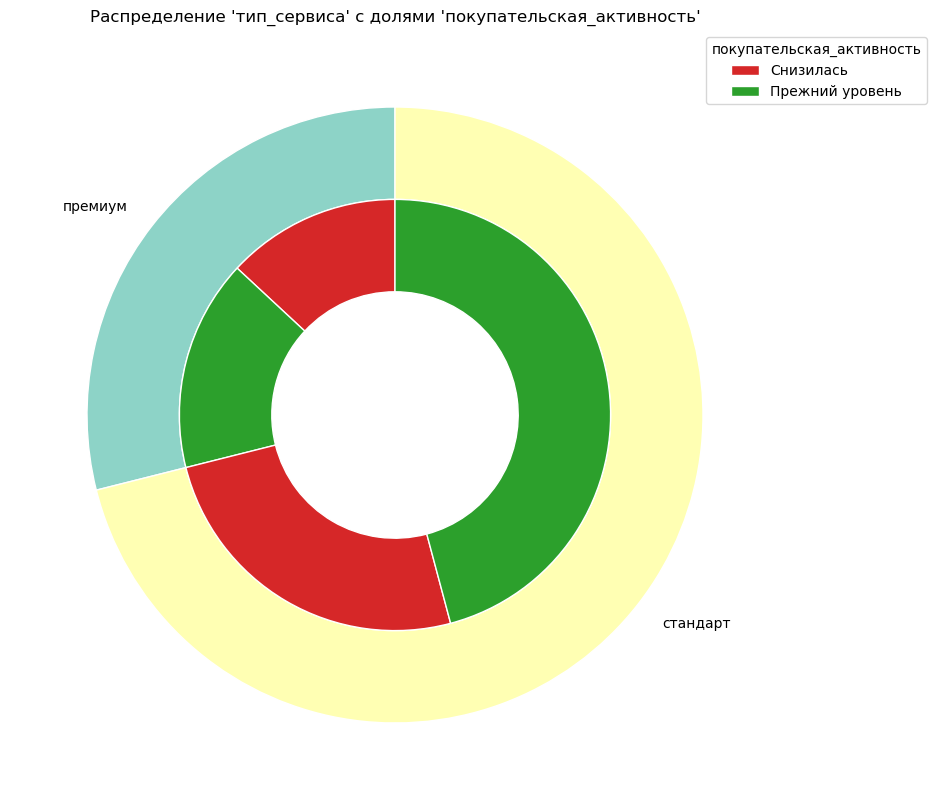

In [54]:
plot_categorical_pie(market, "тип_сервиса")

Чуть менее трети пользователей пользуются подпиской. При этом пользователи, которые **не пользуются подпиской**, имеют более чем **в 2 раза большую вероятность снижения** покупательской **активности**.

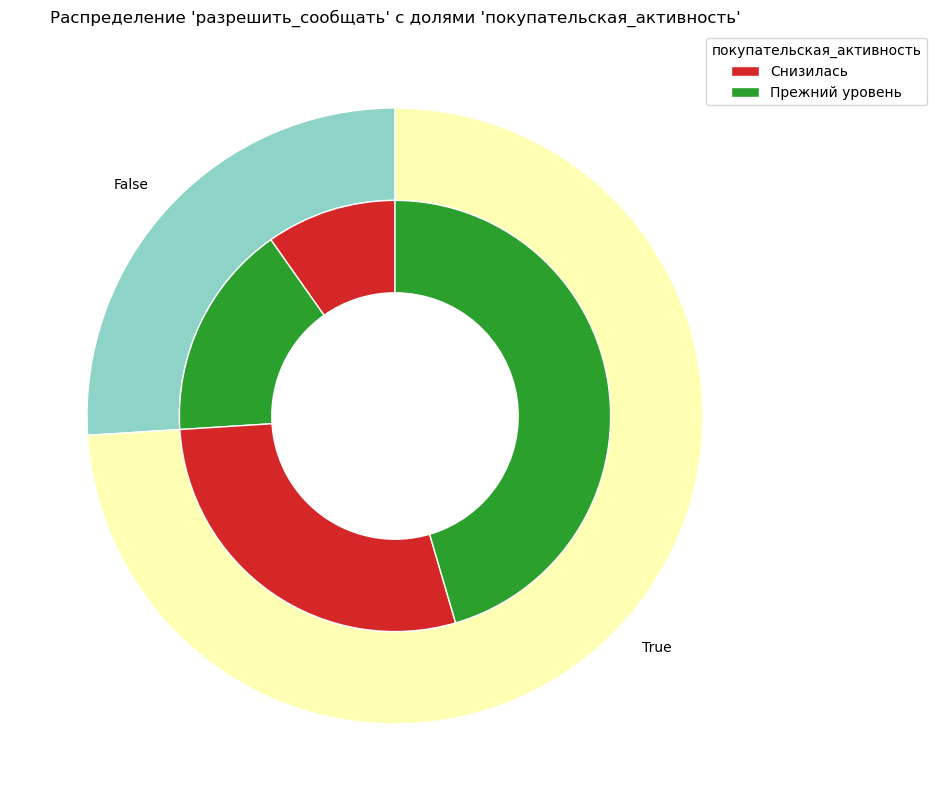

In [55]:
plot_categorical_pie(market, "разрешить_сообщать")

Около четверти пользователей запретили присылать им маркетинговые сообщения. При этом разрешение на маркетинговые коммуникуации почти ни как не влияет на целевой признак.

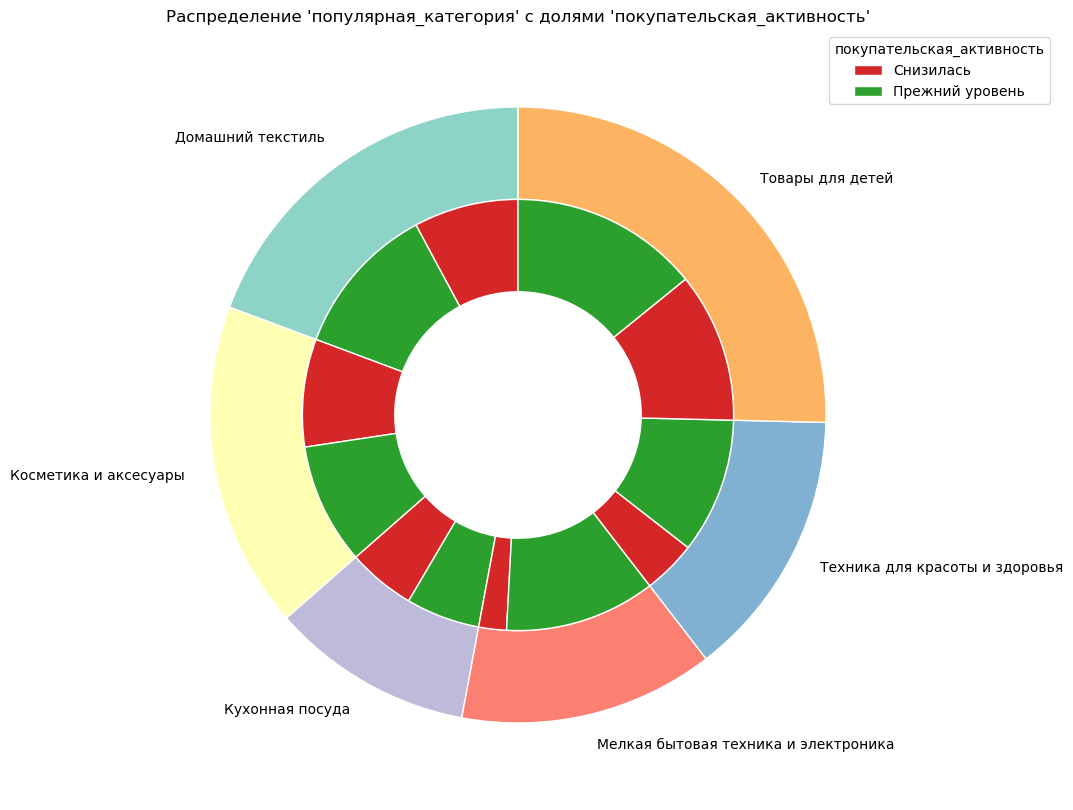

In [56]:
plot_categorical_pie(market, "популярная_категория")

Вероятность **снижения покупательской активности** выше у пользователей, для которых наиболее популярными являются категории:

1) **Косметика и аксесуары**
2) **Кухонная посуда**
3) **Товары для детей**
4) **Домашний текстиль**

Из этого можно сформаировать гиптоезу, что чаще покупательская активность снижается по гендерному признаку у женщин. Требудет дополнительной проверки, можно передать эту информацию в отдел маркетинга.

### Выводы EDA

**Промежуточный вывод**:

Провели ознакомление с данными продаж, очистили данные от выбросов и аномалий, сделали выводы о влиянии признаков на целевой аоказатель активности клиентов.

Клиент, вероятно, снизит свою покупательскую активность если:

1) взаимодествовал менее чем с 4 маркетинговыми активностями в месяц
2) зарегистрирован на платформе примерно от 7 до 14 месяцев назад
3) покупает по акции более 35% товаров
4) просматривает в среднем за раз менее 2 категорий
5) в корзине более 4 неоплаченных товаров за последние 3 месяца
6) просматривает в среднем менее 8 страниз за визит
7) выручка от клиента менее 4800 у.е. двумя месяцами ранее
9) проводит в сервисе менее 12 минут за сессию
10) не пользуется подпиской
11) покупает чаще всего товары из категорий:
- Косметика и аксесуары
- Кухонная посуда
- Товары для детей
- Домашний текстиль

## Объединим таблицы

In [57]:
merged_profit_revenue = pd.merge(merged_revenue, profit, on = "id", how = "left")

Создадим новые колонки на основании периода для времени сессии.

In [58]:
market_time = pd.pivot_table(market_time, values = "минут", index = "id", columns = "период", aggfunc = "sum")
market_time.columns = ["минут_предыдущий_месяц", "минут_текущий_месяц"]
market_time.reset_index(inplace = True)

In [59]:
merged = pd.merge(merged_profit_revenue, market_time, on = "id", how = "inner")

In [60]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   1300 non-null   int64   
 1   покупательская_активность            1300 non-null   category
 2   тип_сервиса                          1300 non-null   category
 3   разрешить_сообщать                   1300 non-null   boolean 
 4   маркет_актив_6_мес                   1300 non-null   float64 
 5   маркет_актив_тек_мес                 1300 non-null   int64   
 6   длительность                         1300 non-null   int64   
 7   акционные_покупки                    1300 non-null   float64 
 8   популярная_категория                 1300 non-null   category
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64   
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64   
 11  ошибка_сервиса   

### Заполним пропуски в новых признаках

Чтобы не искажать статистику заполним пропуски средними.

In [61]:
for col in merged.select_dtypes(include = ["number"]).columns:
    mean_value = merged[col].mean()
    merged[col].fillna(mean_value, inplace = True)

merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   1300 non-null   int64   
 1   покупательская_активность            1300 non-null   category
 2   тип_сервиса                          1300 non-null   category
 3   разрешить_сообщать                   1300 non-null   boolean 
 4   маркет_актив_6_мес                   1300 non-null   float64 
 5   маркет_актив_тек_мес                 1300 non-null   int64   
 6   длительность                         1300 non-null   int64   
 7   акционные_покупки                    1300 non-null   float64 
 8   популярная_категория                 1300 non-null   category
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64   
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64   
 11  ошибка_сервиса   

## Корреляционный анализ

### Корреляционная матрица

Для начала построим кореляционную матрицу в виде тепловой карты.

['маркет_актив_6_мес',
 'маркет_актив_тек_мес',
 'длительность',
 'акционные_покупки',
 'средний_просмотр_категорий_за_визит',
 'неоплаченные_продукты_штук_квартал',
 'ошибка_сервиса',
 'страниц_за_визит',
 'предыдущий_месяц_выручка',
 'препредыдущий_месяц_выручка',
 'текущий_месяц_выручка',
 'прибыль',
 'масштабированная_прибыль',
 'минут_предыдущий_месяц',
 'минут_текущий_месяц']

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка', 'текущий_месяц_выручка', 'прибыль', 'масштабированная_прибыль', 'минут_предыдущий_месяц', 'минут_текущий_месяц']


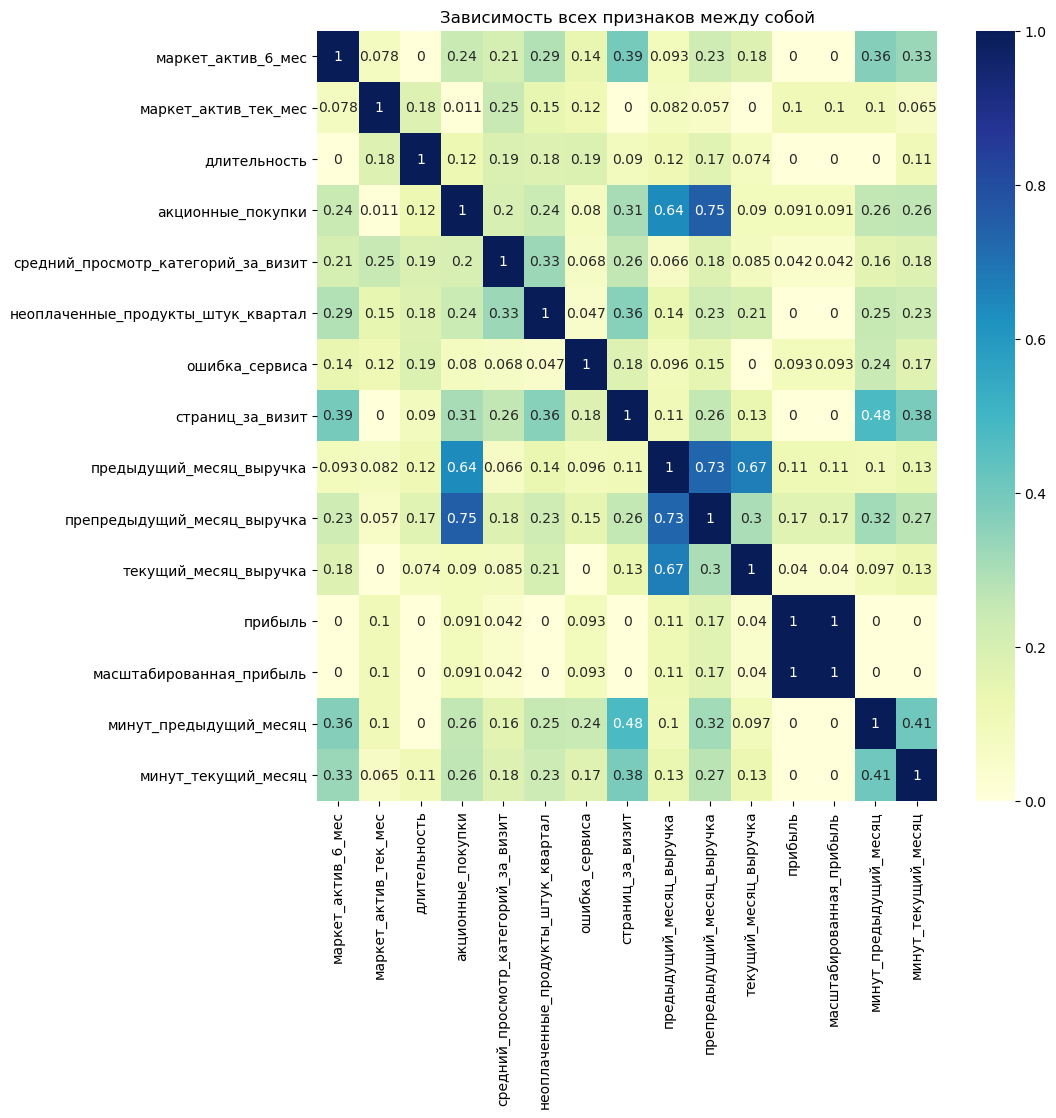

In [62]:
numeric_columns = merged.select_dtypes(include = ["number"]).columns.tolist()
numeric_columns.remove("id")
fig, ax = plt.subplots(figsize=(10,10))  
display(numeric_columns)
phi_k = merged[numeric_columns].phik_matrix()
sns.heatmap(phi_k, cmap = "YlGnBu", annot = True)
ax.set_title("Зависимость всех признаков между собой")
plt.show()

### VIF (коэффициент инфляции дисперсии)

Оценим мультиколлинеарность каждого не содержащего пропусков численного признака в данных при помощи рассчёта коэффициента инфляции дисперсии

In [63]:
X = add_constant(merged[numeric_columns])
VIFs = pd.DataFrame()
VIFs["Variable"] = X.columns
VIFs["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

display(VIFs.sort_values(by = "VIF", ascending = False))

c:\Users\yka\AppData\Local\anaconda3\envs\practicum\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
12,прибыль,inf
13,масштабированная_прибыль,inf
0,const,298.873888
9,предыдущий_месяц_выручка,4.030433
11,текущий_месяц_выручка,3.278799
10,препредыдущий_месяц_выручка,1.852061
14,минут_предыдущий_месяц,1.510978
8,страниц_за_визит,1.416416
15,минут_текущий_месяц,1.309842
1,маркет_актив_6_мес,1.224781


Исходя из корелляционной матрицы и анализа VIF делаем вывод, что мультиколлинеарность в данных почти отсутствует. Наиболее скоррелированным с другими признаками является выручка за предыдущий и текущий месяц. Оставим все признаки в силу их важности.

In [64]:
preproc_merged = merged.drop("предыдущий_месяц_выручка", axis = 1)

## Построение пайплайнов

### Подготовка данных

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    preproc_merged.drop(["id","покупательская_активность"], axis=1),
    preproc_merged["покупательская_активность"],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = preproc_merged["покупательская_активность"])

ohe_columns = ["тип_сервиса", "популярная_категория"]
numeric_columns = preproc_merged.select_dtypes(include = ["number"]).columns.tolist()
numeric_columns.remove("id")
numeric_columns.remove("прибыль")

ohe_pipe = Pipeline(
        [("ohe", OneHotEncoder(drop = "first", handle_unknown = "error", sparse = False))]
    )

numeric_pipe = Pipeline(
    [("num", MinMaxScaler())]
    )

data_preprocessor = ColumnTransformer(
    [("ohe", ohe_pipe, ohe_columns),
     ("num", MinMaxScaler(), numeric_columns)
    ], 
    remainder = "passthrough"
)

### Cоздаём итоговый пайплайн: перебор методов подготовки данных и моделей сразными гиперпараметрами

In [66]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__max_features': range(2, 11),
        'models__min_samples_split': range(2, 11, 2),
        'models__min_samples_leaf': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), 'passthrough']  
    },
    {
        "models": [KNeighborsClassifier(n_jobs = -1)],
        "models__n_neighbors": range(2, 7),
        "models__weights": ["uniform", "distance"],
        "models__algorithm": ["ball_tree", "kd_tree"],
        "models__leaf_size": range(2, 51, 3),
        "models__p": [1, 2],
        "preprocessor__num": [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), "passthrough"]   
    },
    {
        "models": [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver="liblinear",
            n_jobs = -1
        )],
        "models__solver": ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"],
        "models__penalty": ["l1", "l2", "elasticnet"],
        "models__penalty": ["l1", "l2", "elasticnet"],
        "models__C": [1, 2, 4, 8, 16, 32],
        "preprocessor__num": [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), "passthrough"]  
    },
    {
        "models": [SVC(
            random_state=RANDOM_STATE
        )],
        "models__C": [1, 2, 4, 8, 16, 32],
        "models__kernel": ["linear", "poly", "rbf", "sigmoid"],
        "models__degree": [2, 3, 4, 5],
        "models__gamma": ["scale", "auto"],
        "preprocessor__num": [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), "passthrough"]  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    n_iter = 30,
    cv = 5,
    scoring = "roc_auc",
    random_state = RANDOM_STATE,
    n_jobs = -1
)

randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse=False))]),
                                                                               ['тип_сервиса',
                                                                                'популярная_категория']),
                                                                              ('num',
                                                                               MinMaxScaler(),
                                                                               ['маркет_актив_6_мес',
                                                                                'маркет_актив_тек_мес',
                                                                                'длительность',
                                                                                'акционные_покупки',
                                                                                'средний_про...
                                                               RobustScaler(),
                                                               MaxAbsScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(random_state=1)],
                                         'models__C': [1, 2, 4, 8, 16, 32],
                                         'models__degree': [2, 3, 4, 5],
                                         'models__gamma': ['scale', 'auto'],
                                         'models__kernel': ['linear', 'poly',
                                                            'rbf', 'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               MaxAbsScaler(),
                                                               'passthrough']}],
                   random_state=1, scoring='roc_auc')

### Выбор метрики

Для задачи выбрана метрика ROC AUC т.к. она более робастная, подходит для задачи бинарной классификации и позволяет объективнее оценить обобщающую способность разных моделей вне зависимости от их гиперпараметров.

In [67]:
display("Лучшая модель и её параметры:\n\n", randomized_search.best_estimator_)
display ("Метрика лучшей модели на тренировочной выборке:", randomized_search.best_score_)

y_test_pred = randomized_search.predict_proba(X_test)[:,1]

display(f"Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}")

'Лучшая модель и её параметры:\n\n'

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['тип_сервиса',
                                                   'популярная_категория']),
                                                 ('num', StandardScaler(),
                                                  ['маркет_актив_6_мес',
                                                   'маркет_актив_тек_мес',
                                                   'длительность',
                                                   'акционные_покупки',
                                                   'средний_просмотр_категорий_за_визит',
                                                   'неоплаченные_продукты_штук_квартал',
                                                   'ошибка_сервиса',
                                                   'страниц_за_визит',
                                                   'препредыдущий_месяц_выручка',
                                                   'текущий_месяц_выручка',
                                                   'масштабированная_прибыль',
                                                   'минут_предыдущий_месяц',
                                                   'минут_текущий_месяц'])])),
                ('models',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=20,
                                      n_jobs=-1, n_neighbors=6,
                                      weights='distance'))])

'Метрика лучшей модели на тренировочной выборке:'

0.8963124210393975

'Метрика ROC-AUC на тестовой выборке: 0.8844374999999999'

### Вывод подбора модели

**Наилучшей** моделью оказалась **модель ближайших соседей** с количеством рассматритваемых соседей 4 и расстоянием считаемым по манхеттенской метрике со значением метрики **ROC AUC близким к 0.88** на тестовой выборке. Такое значение точности выглядит правдоподобным и удовлетворительным

## Анализ важности признаков

Для анализа значимости признаков рассчитаем значения Шепли. Семплируем тестовую выборку для адекватного соотношения времени ожидания перебора параметров, репрезентативности выборки и стабильности резултатов.

In [68]:
def model_predict(x):
    return randomized_search.best_estimator_.predict_proba(x)[:, 1]

sampled_train = shap.sample(X_train, 500, random_state = RANDOM_STATE)
sampled_test = shap.sample(X_test, 500, random_state = RANDOM_STATE)
explainer = shap.KernelExplainer(model_predict, sampled_train, keep_index = True, keep_index_ordered = True)
shap_values = shap.Explanation(explainer.shap_values(sampled_test), feature_names = sampled_test.columns)

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/260 [00:00<?, ?it/s]

### График влияния признаков на предсказания классов

- В силу масштабирования данных в ходе предобработки все признаки имеют примерно одинаковые диапазоны значений, что отражено монохромностью точек на графике. 

- Часто конкретные признаки никак не влияют на предсказание модели.

- В более редких случаях, модель чаще склоняется к тому, что пользователь сохранит свою покупательскую активность.

- Заметно, что при снижении покупательской активности пользователей, модель "увереннее" присваивает класс на основании любого из признаков.

- При снижении покупательской активности модель незначительно больше учитывает более значимые признаки, чем менее значимые.

### График значимости признаков

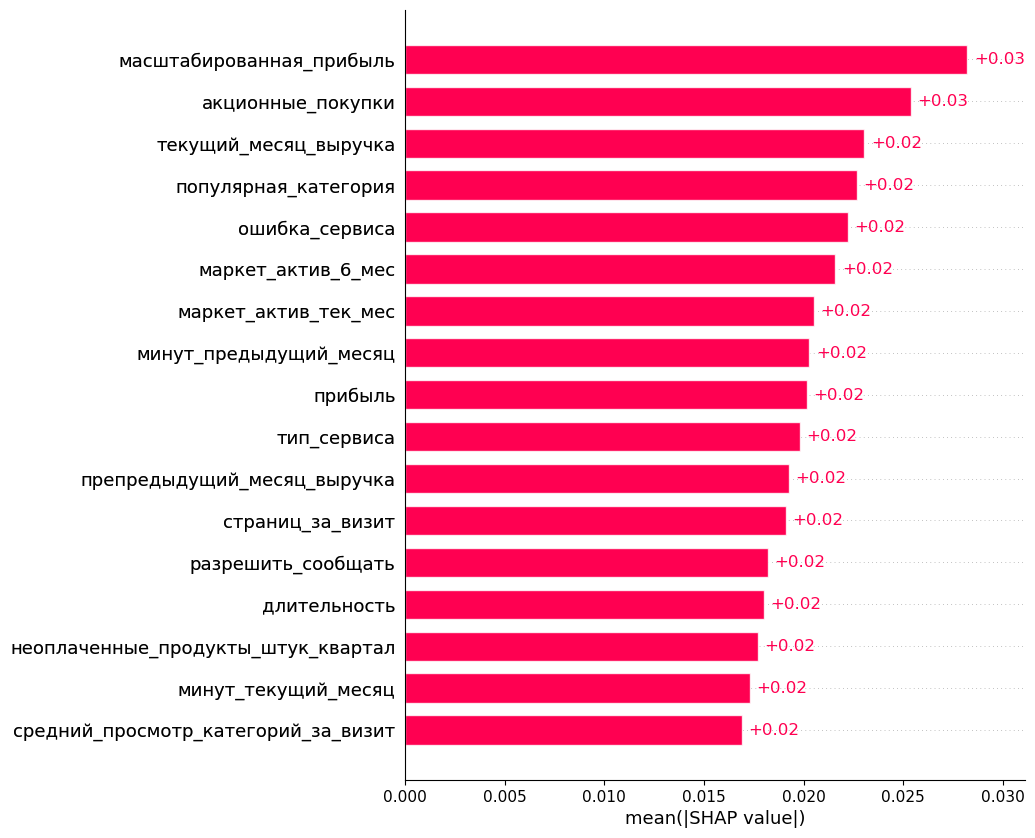

In [69]:
shap.plots.bar(shap_values, max_display = 18)

- Наиболее важными для предсказания покупательской активности являются прибыль от него, количество акционных покупок и выручка от него в этом месяце.

- Значимость остальных признаков равномерно убывает, но при этом остаётся достаточно существенной, чтобы их оставить.

- Наименее значимыми оказались средняя продолжительность сессии клиента и количество просматреваемых за визит категорий.

### Выводы анализа влияния признаков

Стоит сосредоточиться на:

- Финансовых показателях пользователей

- Количестве невыкупленных товаров для повышения удержания клиентов

## Сегментация покупателей

Применяем модель ко всему набору данных для получения оценок пользователйской активности модели

In [70]:
X_full = preproc_merged.drop(["id", "покупательская_активность"], axis = 1)

predictions = randomized_search.best_estimator_.predict_proba(X_full)[:, 1]

segmented = merged.copy()
segmented["нужно_удержание"] = predictions

Рассмотрим распределение вероятностей необходимости удержания клиентов.

(array([729.,  54.,   1.,  28.,   6.,   7.,   8.,   1.,  13., 453.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

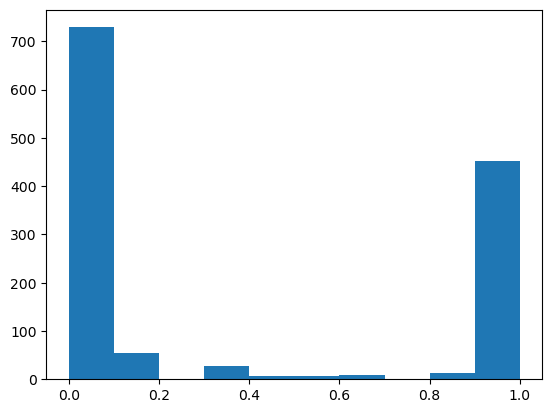

In [71]:
plt.hist(predictions)

Видно, что модель присваивает абсолютные значения вероятности для большинства клиентов.

Сегментируем покупателей по прибыли от них и необходимости действой по удержанию.

In [72]:
clustering_features = ["масштабированная_прибыль", "нужно_удержание"]
X_cluster = segmented[clustering_features].fillna(segmented[clustering_features].mean())
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE)
segmented['segment'] = kmeans.fit_predict(X_cluster_scaled)


In [73]:
segmented.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,прибыль,масштабированная_прибыль,минут_предыдущий_месяц,минут_текущий_месяц,нужно_удержание,segment
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923,4936.920385,4825.206923,5232.759154,3.996631,3996.630769,13.467692,13.204615,0.380686,1.274615
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126,739.597997,405.979663,847.688587,1.013722,1013.722112,3.932029,4.220589,0.469067,1.104600
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.860000,860.000000,5.000000,4.000000,0.000000,0.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000,4496.750000,4583.000000,4703.850000,3.300000,3300.000000,11.000000,10.000000,0.000000,0.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000,5005.000000,4809.000000,5179.550000,4.045000,4045.000000,13.000000,13.000000,0.000000,1.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000,5405.625000,5053.500000,5759.275000,4.670000,4670.000000,17.000000,16.000000,1.000000,2.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000,6869.500000,5663.000000,7799.400000,7.430000,7430.000000,23.000000,23.000000,1.000000,3.000000


Описательная статистика выглядит адекватно. Явных аномалий не замечено.

### Квадранты сегментации клиентов

Разделение по вероятности снижения активности клиента будем делать по 0.5 т.к. логично рассматривать этот признак как бинарный. 

Для значений прибыльности клиентов сделаем раздиление по средней прибыльности т.к. ранее мы наблюдали нормальное распределение для этого признака.

'Порог для удержания: 0.5'

'Порог для прибыли: 3996.63'

'Количество пользователей в каждом сегменте:'

1    427
0    393
3    270
2    210
Name: segment, dtype: int64

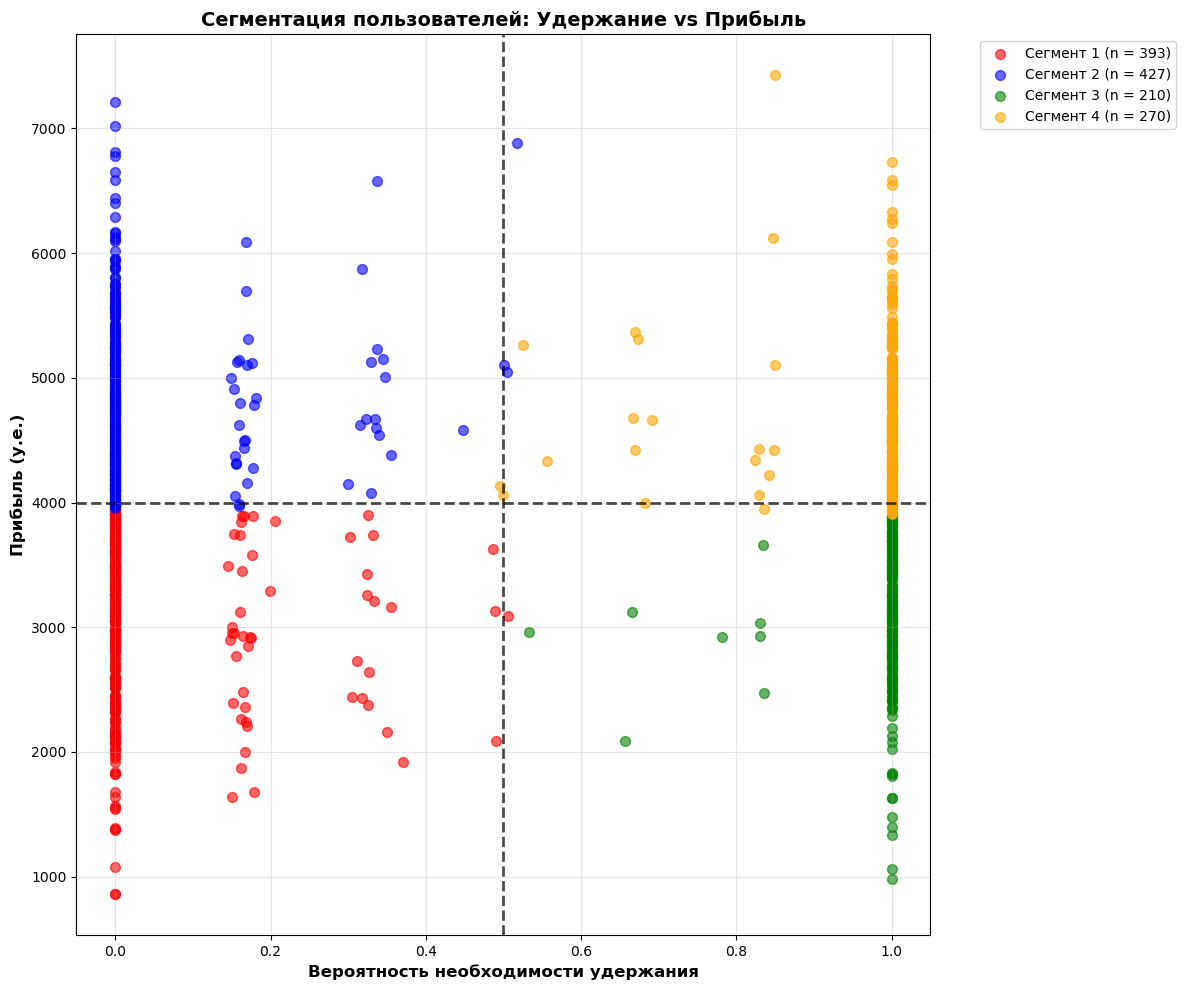

In [74]:
retention_threshold = 0.5
profit_threshold = segmented["масштабированная_прибыль"].mean()

display(f"Порог для удержания: {retention_threshold}")
display(f"Порог для прибыли: {profit_threshold:.2f}")
display(f"Количество пользователей в каждом сегменте:")
display(segmented["segment"].value_counts())

plt.figure(figsize = (12, 10))

colors = ["red", "blue", "green", "orange"]
segment_names = ["Сегмент 1", "Сегмент 2", "Сегмент 3", "Сегмент 4"]

for segment_id in range(4):
    segment_data = segmented[segmented["segment"] == segment_id]
    plt.scatter(segment_data["нужно_удержание"],
                segment_data["масштабированная_прибыль"],
                c = colors[segment_id],
                alpha = 0.6,
                s = 50,
                label = f"{segment_names[segment_id]} (n = {len(segment_data)})")

plt.axhline(y = profit_threshold, color = "black", linestyle = "--", linewidth = 2, alpha = 0.7)
plt.axvline(x = retention_threshold, color = "black", linestyle = "--", linewidth = 2, alpha = 0.7)

plt.xlabel("Вероятность необходимости удержания", fontsize = 12, fontweight = "bold")
plt.ylabel("Прибыль (у.е.)", fontsize = 12, fontweight = "bold")
plt.title("Сегментация пользователей: Удержание vs Прибыль", fontsize = 14, fontweight = "bold")



plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left")
plt.grid(True, alpha = 0.3)


plt.tight_layout()
plt.show()

Для бизнеса в первую очередь стоит сфокусировать внимание на клиентах с высокой прибыльностью, которые теряют активность. На графике это 3 сегмент, обозначенный зелёным цветом.

### Анализ распределения по квадрантам

In [75]:
def get_quadrant(row):
    retention = row["нужно_удержание"]
    profit = row["масштабированная_прибыль"]

    if retention >= retention_threshold and profit >= profit_threshold:
        return "Квадрант 1: Нужно удержание + Высокая прибыль"
    elif retention < retention_threshold and profit >= profit_threshold:
        return "Квадрант 2: Не нужно удержание + Высокая прибыль"
    elif retention < retention_threshold and profit < profit_threshold:
        return "Квадрант 3: Не нужно удержание + Низкая прибыль"
    else:
        return "Квадрант 4: Нужно удержание + Низкая прибыль"

segmented["quadrant"] = segmented.apply(get_quadrant, axis=1)

quadrant_counts = segmented["quadrant"].value_counts()
display("Распределение пользователей по квадрантам:")
display(quadrant_counts)
display("\nПроцентное распределение:")
display(f"{(quadrant_counts / len(segmented) * 100).round(1)} %")

'Распределение пользователей по квадрантам:'

Квадрант 2: Не нужно удержание + Высокая прибыль    415
Квадрант 3: Не нужно удержание + Низкая прибыль     403
Квадрант 1: Нужно удержание + Высокая прибыль       258
Квадрант 4: Нужно удержание + Низкая прибыль        224
Name: quadrant, dtype: int64

'\nПроцентное распределение:'

'Квадрант 2: Не нужно удержание + Высокая прибыль    31.9\nКвадрант 3: Не нужно удержание + Низкая прибыль     31.0\nКвадрант 1: Нужно удержание + Высокая прибыль       19.8\nКвадрант 4: Нужно удержание + Низкая прибыль        17.2\nName: quadrant, dtype: float64 %'

Пользователей, на которых в первую очередь стоит обратить внимание в текущем наборе данных примерно пятая часть.

In [76]:
premium = segmented[segmented["quadrant"] == "Квадрант 1: Нужно удержание + Высокая прибыль"]

### Идеи удержания пользователей

Проверим возможности предоставить пользователям скидки.

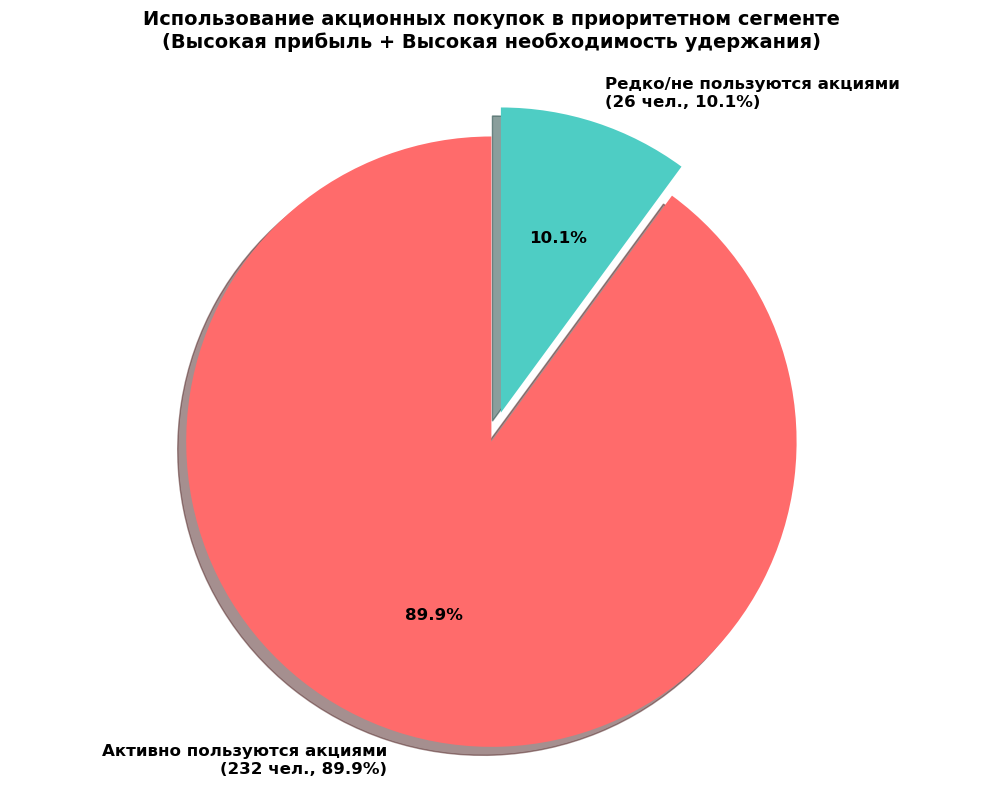

In [77]:
promo_active_threshold = 0.2

promo_users = premium[premium["акционные_покупки"] > promo_active_threshold]
non_promo_users = premium[premium["акционные_покупки"] <= promo_active_threshold]

promo_counts = [len(promo_users), len(non_promo_users)]
promo_labels = [
    f"Активно пользуются акциями\n({len(promo_users)} чел., {len(promo_users)/len(premium)*100:.1f}%)",
    f"Редко/не пользуются акциями\n({len(non_promo_users)} чел., {len(non_promo_users)/len(premium)*100:.1f}%)"
]

plt.figure(figsize = (10, 8))
colors = ["#FF6B6B", "#4ECDC4"]

plt.pie(promo_counts,
        labels = promo_labels,
        colors = colors,
        autopct = "%1.1f%%",
        startangle = 90,
        explode = (0.1, 0),
        shadow = True,
        textprops = {"fontsize": 12, "fontweight": "bold"})

plt.title("Использование акционных покупок в приоритетном сегменте\n(Высокая прибыль + Высокая необходимость удержания)",
          fontsize = 14, fontweight = "bold", pad = 20)

plt.axis("equal")
plt.tight_layout()
plt.show()

Пользователям, которые совершают менее 20% покупок по акции можно чаще предоставлять скидки. Но таких пользователей меньшенство, около 10%, что не приведёт к значительному повышени. удержания клиентов.

Проверим количество ошибок сервиса, с которыми сталкиваются премиальные пользователи.

C:\Users\yka\AppData\Local\Temp\ipykernel_23168\2820058631.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  premium["service_error_category"] = premium["ошибка_сервиса"].apply(categorize_service_errors)


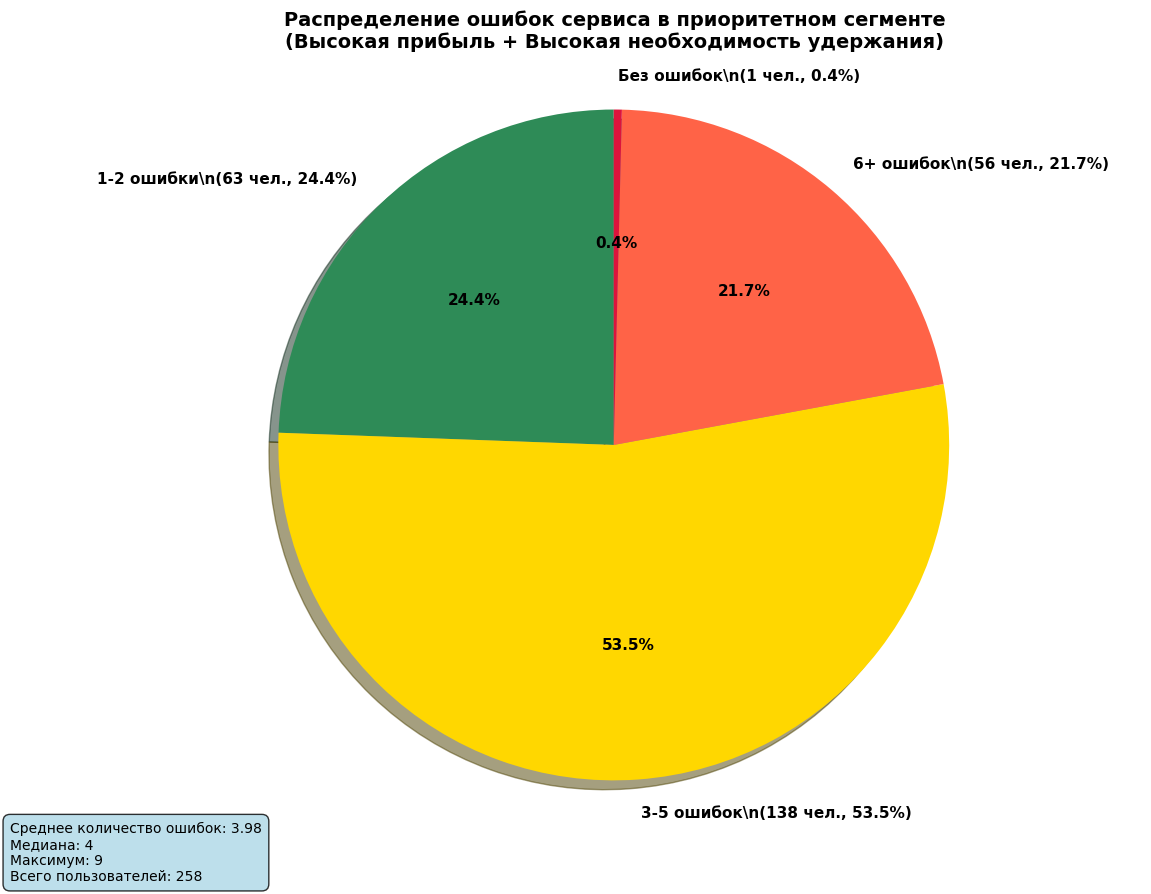

In [78]:
def categorize_service_errors(errors_count):
    if errors_count == 0:
        return "Без ошибок"
    elif errors_count <= 2:
        return "1-2 ошибки"
    elif errors_count <= 5:
        return "3-5 ошибок"
    else:
        return "6+ ошибок"

premium["service_error_category"] = premium["ошибка_сервиса"].apply(categorize_service_errors)
error_categories = premium["service_error_category"].value_counts().sort_index()

plt.figure(figsize = (12, 9))

colors = ["#2E8B57", "#FFD700", "#FF6347", "#DC143C"]

plt.pie(error_categories.values,
        labels = [f"{cat}\\n({count} чел., {count/len(premium)*100:.1f}%)"
                for cat, count in error_categories.items()],
        colors = colors,
        autopct = "%1.1f%%",
        startangle = 90,
        shadow = True,
        textprops = {"fontsize": 11, "fontweight": "bold"})

plt.title("Распределение ошибок сервиса в приоритетном сегменте\n(Высокая прибыль + Высокая необходимость удержания)",
          fontsize = 14, fontweight = "bold", pad = 20)

stats_text = f"Среднее количество ошибок: {premium['ошибка_сервиса'].mean():.2f}\n" \
             f"Медиана: {premium['ошибка_сервиса'].median():.0f}\n" \
             f"Максимум: {premium['ошибка_сервиса'].max()}\n" \
             f"Всего пользователей: {len(premium)}"

plt.text(-1.8, -1.3, stats_text,
         fontsize = 10, bbox = dict(boxstyle = "round,pad=0.5", facecolor = "lightblue", alpha = 0.8))

plt.axis("equal")
plt.tight_layout()
plt.show()

Для премиальных пользователей количество ошибок не сильно отличается от общего распределения для всех клиентов. Вряд ли можно как-то повлиять на их удержание исходя из этого показателя.

Рассмотрим распределение премиальных пользователей по типам сервиса.

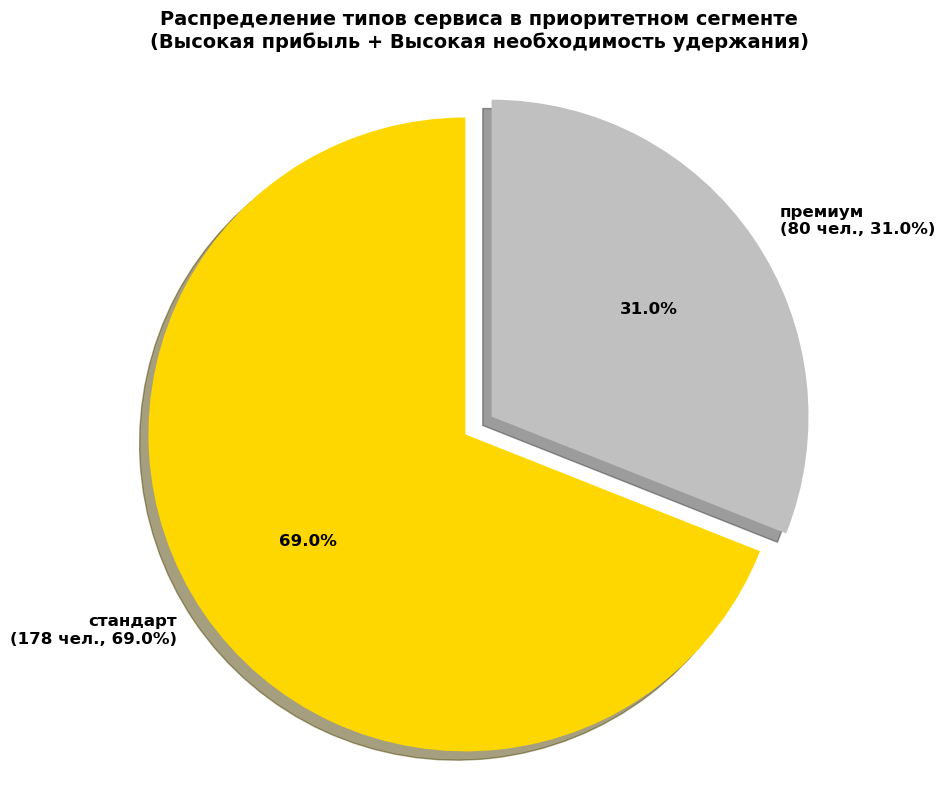

In [79]:
service_type_counts = premium["тип_сервиса"].value_counts()

plt.figure(figsize = (10, 8))

colors = ["#FFD700", "#C0C0C0"]

plt.pie(service_type_counts.values,
        labels = [f"{service_type}\n({count} чел., {count/len(premium)*100:.1f}%)"
                for service_type, count in service_type_counts.items()],
        colors = colors,
        autopct = "%1.1f%%",
        startangle = 90,
        explode = (0.1, 0),
        shadow = True,
        textprops = {"fontsize": 12, "fontweight": "bold"})

plt.title("Распределение типов сервиса в приоритетном сегменте\n(Высокая прибыль + Высокая необходимость удержания)",
          fontsize = 14, fontweight = "bold", pad = 20)

plt.axis("equal")
plt.tight_layout()
plt.show()

Среди премиальных клиентов схожее с общим распределение покупки подписок. Только треть пользуется подпиской на сервис. **Можно продумать специальное предложение подписки на сервис премиальным клиентам для повышения их удержания**, т.к. такой шаг будет актуален для большинства премиальных клиентов в силу отсутствия у них подписки.

Проанализируем популярные среди премиальных пользователей категории и среднюю прибыльность для бизнеса каждой из них.

In [80]:


def plot_category_pie_with_profit_gradient(
    df: pd.DataFrame,
    category_col: str = "популярная_категория",
    profit_col: str = "масштабированная_прибыль",
    top_n: int = 8,
    title: str = "Популярные категории товаров в приоритетном сегменте\n(Высокая прибыль + Высокая необходимость удержания)",
    yellow_hex: str = "#F7DC6F",
    green_hex: str = "#2ECC71",
    others_label: str = "Другие",
    others_color: str = "#B0BEC5",
    explode_value: float = 0.05
):
    category_counts = df[category_col].value_counts()
    top_categories = category_counts.head(top_n)
    other_count = int(category_counts.iloc[top_n:].sum())
    has_others = other_count > 0

    if has_others:
        top_categories[others_label] = other_count

    profit_by_cat = (
        df[[category_col, profit_col]]
        .groupby(category_col)[profit_col]
        .mean()
    )
    real_top_cats = [c for c in top_categories.index if c != others_label]
    real_means = profit_by_cat.reindex(real_top_cats)
    vmin = float(np.nanmin(real_means.values)) if len(real_means) else 0.0
    vmax = float(np.nanmax(real_means.values)) if len(real_means) else 1.0

    if np.isclose(vmin, vmax):
        vmin -= 0.5
        vmax += 0.5

    norm = Normalize(vmin = vmin, vmax = vmax)
    cmap = LinearSegmentedColormap.from_list("profit_cmap", [yellow_hex, green_hex])

    colors = []
    for cat in top_categories.index:
        if cat == others_label:
            colors.append(others_color)
        else:
            mean_profit = profit_by_cat.get(cat, np.nan)
            colors.append(cmap(norm(mean_profit)))

    total = len(df)
    labels = []
    
    for cat, count in top_categories.items():
        pct = 100 * count / total if total > 0 else 0
        if cat == others_label:
            labels.append(f"{cat}\n({count} чел., {pct:.1f}%)")
        else:
            mean_profit = profit_by_cat.get(cat, np.nan)
            profit_txt = "н/д" if pd.isna(mean_profit) else f"{mean_profit:,.2f}".replace(",", " ")
            labels.append(f"{cat}\n({count} чел, {pct:.1f}% | ср. прибыль: {profit_txt})")

    explode = [explode_value] * len(top_categories)

    fig, ax = plt.subplots(figsize=(18, 10))
    wedges, texts, autotexts = ax.pie(
        top_categories.values,
        labels = labels,
        colors = colors,
        autopct = "%1.1f%%",
        startangle = 90,
        explode = explode,
        shadow = True,
        textprops = {"fontsize": 10, "fontweight": "bold"},
        wedgeprops = dict(linewidth = 1, edgecolor = "white")
    )
    ax.set_title(title, fontsize = 14, fontweight = "bold", pad = 20)
    ax.axis("equal")

    sm = ScalarMappable(norm = norm, cmap = cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax = ax, fraction = 0.046, pad = 0.04)
    cbar.set_label("Среднее значение на пользователя (по категории) в у.е.", fontsize = 11)

    plt.show()

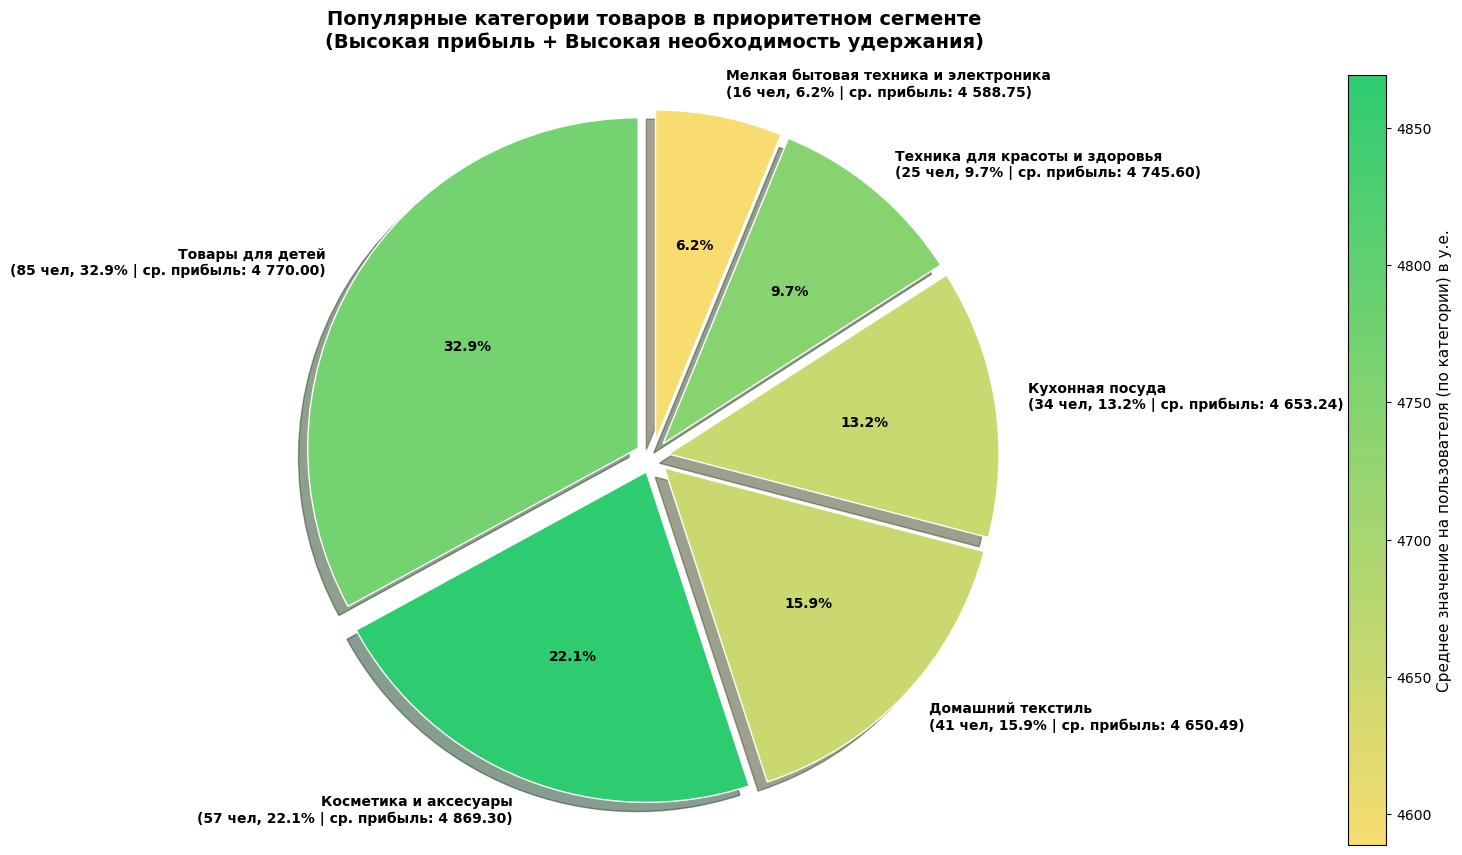

In [81]:
plot_category_pie_with_profit_gradient(
    df = premium,
    category_col = "популярная_категория",
    profit_col = "масштабированная_прибыль",
    top_n = 8
)

Схожие со всеми остальными пользователями значения популярности категорий товаров. Заметно, какие категории товаров в премиальном сегменте пользователей приносят наибольшую прибыльность компании:
1) Косметика и аксессуары
2) Товары для детей и дома
3) Техника для красоты и здоровья

Далее рассмотрим на динамику выручки в разных категориях товаров от премиальных пользователей по последним месяцам.

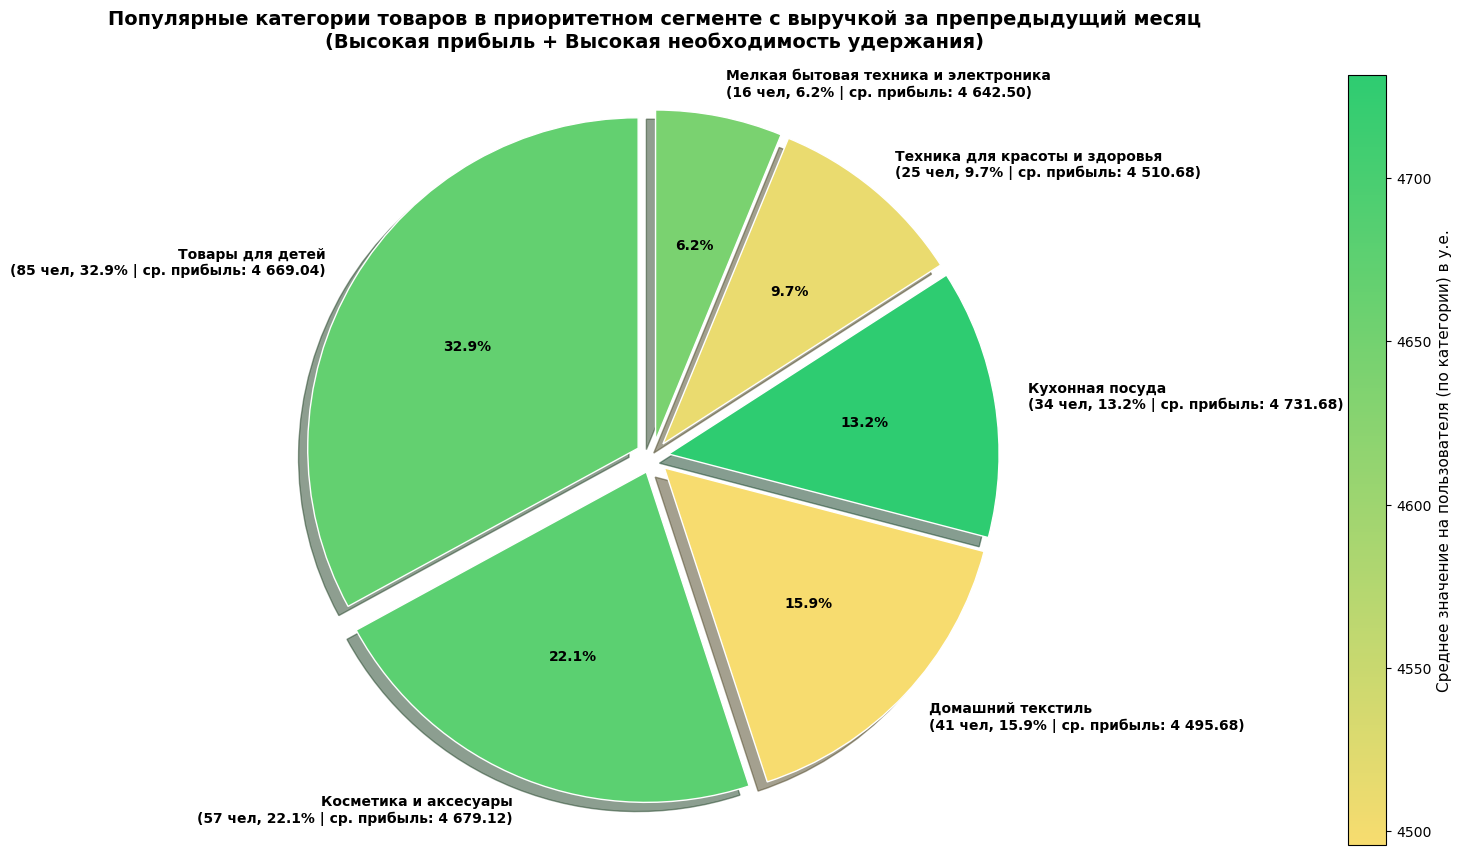

In [82]:
plot_category_pie_with_profit_gradient(
    df = premium,
    category_col = "популярная_категория",
    profit_col = "препредыдущий_месяц_выручка",
    top_n = 8,
    title = "Популярные категории товаров в приоритетном сегменте с выручкой за препредыдущий месяц\n(Высокая прибыль + Высокая необходимость удержания)"
)

In [83]:
premium.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258 entries, 1 to 1259
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   258 non-null    int64   
 1   покупательская_активность            258 non-null    category
 2   тип_сервиса                          258 non-null    category
 3   разрешить_сообщать                   258 non-null    boolean 
 4   маркет_актив_6_мес                   258 non-null    float64 
 5   маркет_актив_тек_мес                 258 non-null    int64   
 6   длительность                         258 non-null    int64   
 7   акционные_покупки                    258 non-null    float64 
 8   популярная_категория                 258 non-null    category
 9   средний_просмотр_категорий_за_визит  258 non-null    int64   
 10  неоплаченные_продукты_штук_квартал   258 non-null    int64   
 11  ошибка_сервиса    

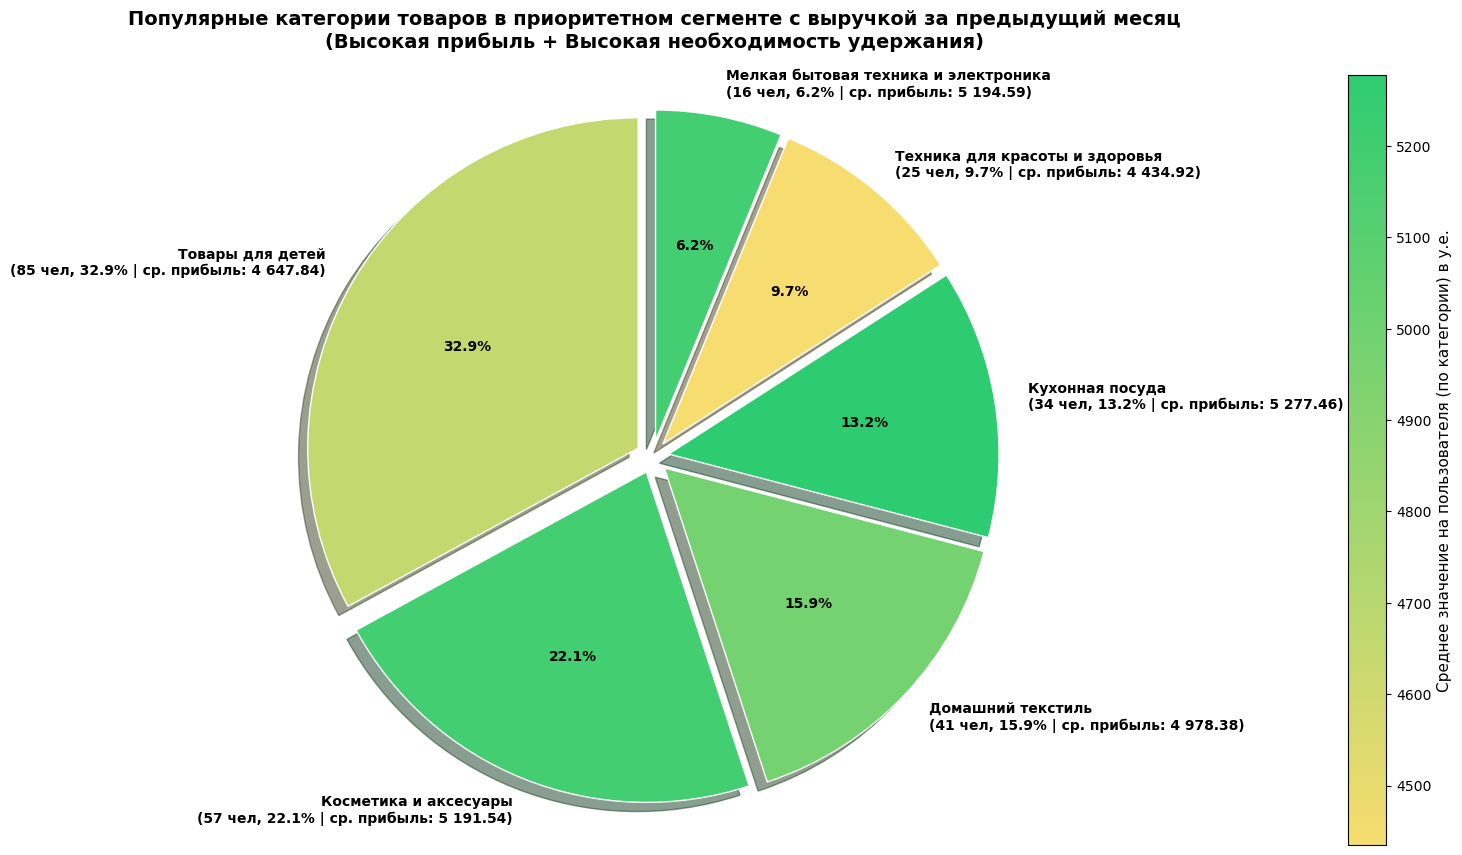

In [84]:
plot_category_pie_with_profit_gradient(
    df = premium,
    category_col = "популярная_категория",
    profit_col = "предыдущий_месяц_выручка",
    top_n = 8,
    title = "Популярные категории товаров в приоритетном сегменте с выручкой за предыдущий месяц\n(Высокая прибыль + Высокая необходимость удержания)"
)

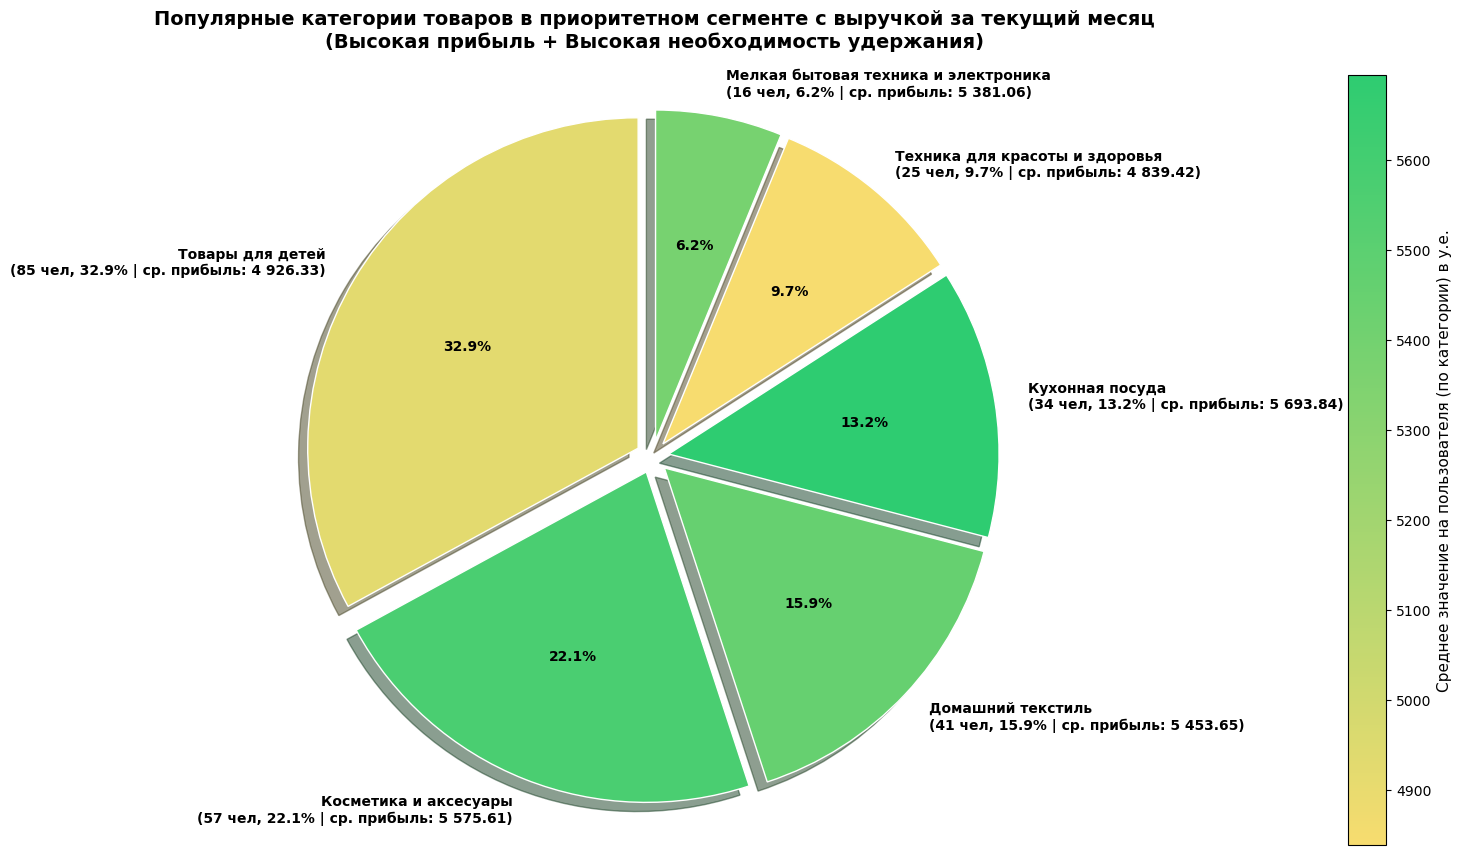

In [85]:
plot_category_pie_with_profit_gradient(
    df = premium,
    category_col = "популярная_категория",
    profit_col = "текущий_месяц_выручка",
    top_n = 8,
    title = "Популярные категории товаров в приоритетном сегменте с выручкой за текущий месяц\n(Высокая прибыль + Высокая необходимость удержания)"
)

- Стабильно высокая выручка от премиальных пользователей в сегментах кухонной посуды и косметики и аксессуаров
- За последние два месяца упала выручка в сегментах техники для красоты и здоровья, товаров для детей
- За последние 2 месяца повысилась выручка в сегментах мелкой бытовой техники и электроники, домашнего текстиля

Проанализируем частоту маркетинговых активностей для премиальных пользователей за последние 6 месяцев.

C:\Users\yka\AppData\Local\Temp\ipykernel_23168\1922604291.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  premium["marketing_category"] = premium["маркет_актив_6_мес"].apply(categorize_marketing_activity)


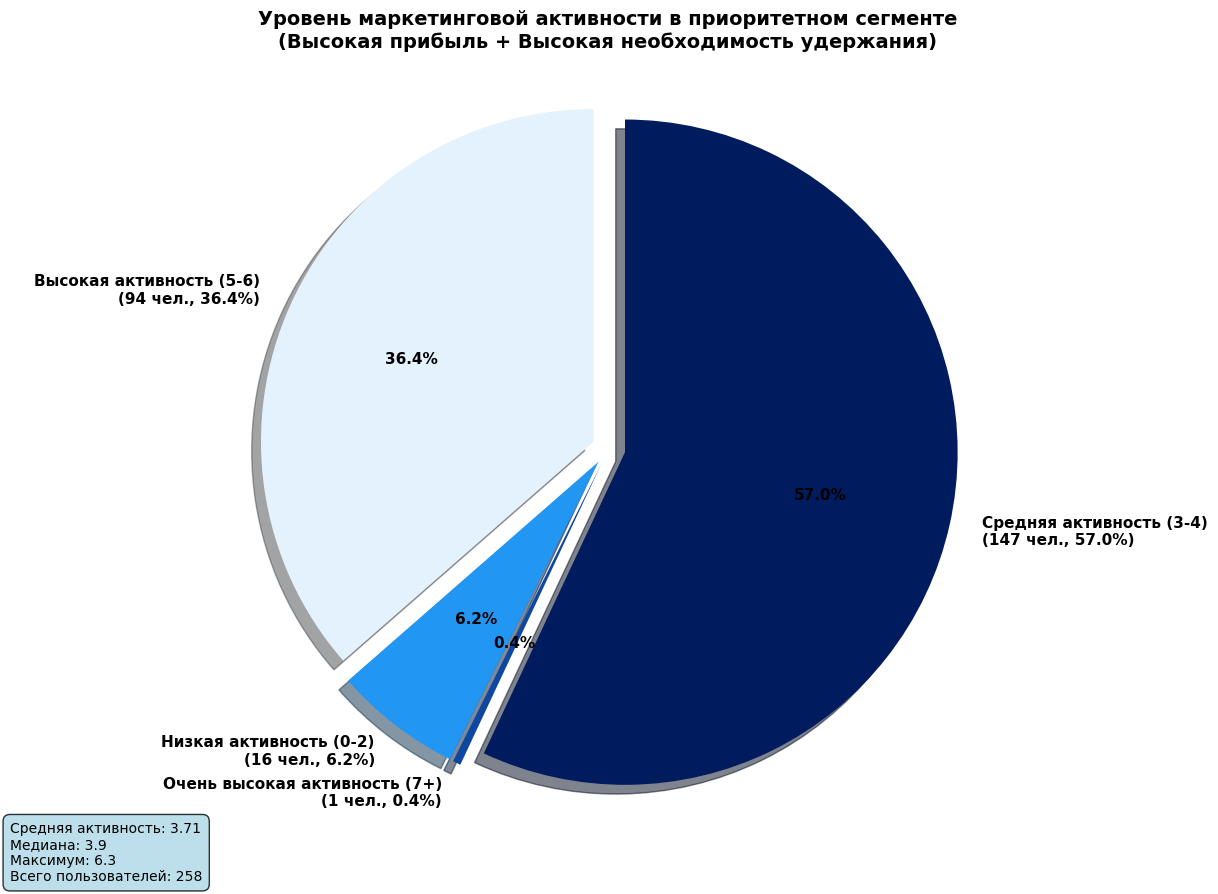

In [86]:
def categorize_marketing_activity(activity_level):
    if activity_level <= 2:
        return "Низкая активность (0-2)"
    elif activity_level <= 4:
        return "Средняя активность (3-4)"
    elif activity_level <= 6:
        return "Высокая активность (5-6)"
    else:
        return "Очень высокая активность (7+)"

premium["marketing_category"] = premium["маркет_актив_6_мес"].apply(categorize_marketing_activity)
marketing_categories = premium["marketing_category"].value_counts().sort_index()


plt.figure(figsize = (12, 9))

colors = ["#E3F2FD", "#2196F3", "#0D47A1", "#001B5E"]

plt.pie(marketing_categories.values,
        labels = [f"{cat}\n({count} чел., {count/len(premium)*100:.1f}%)"
                for cat, count in marketing_categories.items()],
        colors = colors,
        autopct = "%1.1f%%",
        startangle = 90,
        explode = (0.05, 0.05, 0.05, 0.05),
        shadow = True,
        textprops = {"fontsize": 11, "fontweight": "bold"})

plt.title("Уровень маркетинговой активности в приоритетном сегменте\n(Высокая прибыль + Высокая необходимость удержания)",
          fontsize = 14, fontweight = "bold", pad = 20)

avg_activity = premium["маркет_актив_6_мес"].mean()
median_activity = premium["маркет_актив_6_мес"].median()
max_activity = premium["маркет_актив_6_мес"].max()

stats_text = f"Средняя активность: {avg_activity:.2f}\n" \
             f"Медиана: {median_activity:.1f}\n" \
             f"Максимум: {max_activity:.1f}\n" \
             f"Всего пользователей: {len(premium)}"

plt.text(-1.8, -1.3, stats_text,
         fontsize = 10, bbox = dict(boxstyle = "round,pad=0.5", facecolor = "lightblue", alpha = 0.8))

plt.axis("equal")
plt.tight_layout()
plt.show()

Для большинства пользователей из премиальной категории с высокой вероятноситью снижения активности за последние 6 месяцев наблюдалась высокая либо средняя маркетинговая активность. Вероятно, пользователям надоедает излишне назойливая реклама. Есть смысл подумать об изменениях маркетиинговой статегии для премиальных пользователей.

C:\Users\yka\AppData\Local\Temp\ipykernel_23168\2634091618.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  premium["unpaid_category"] = x.apply(categorize_unpurchased)


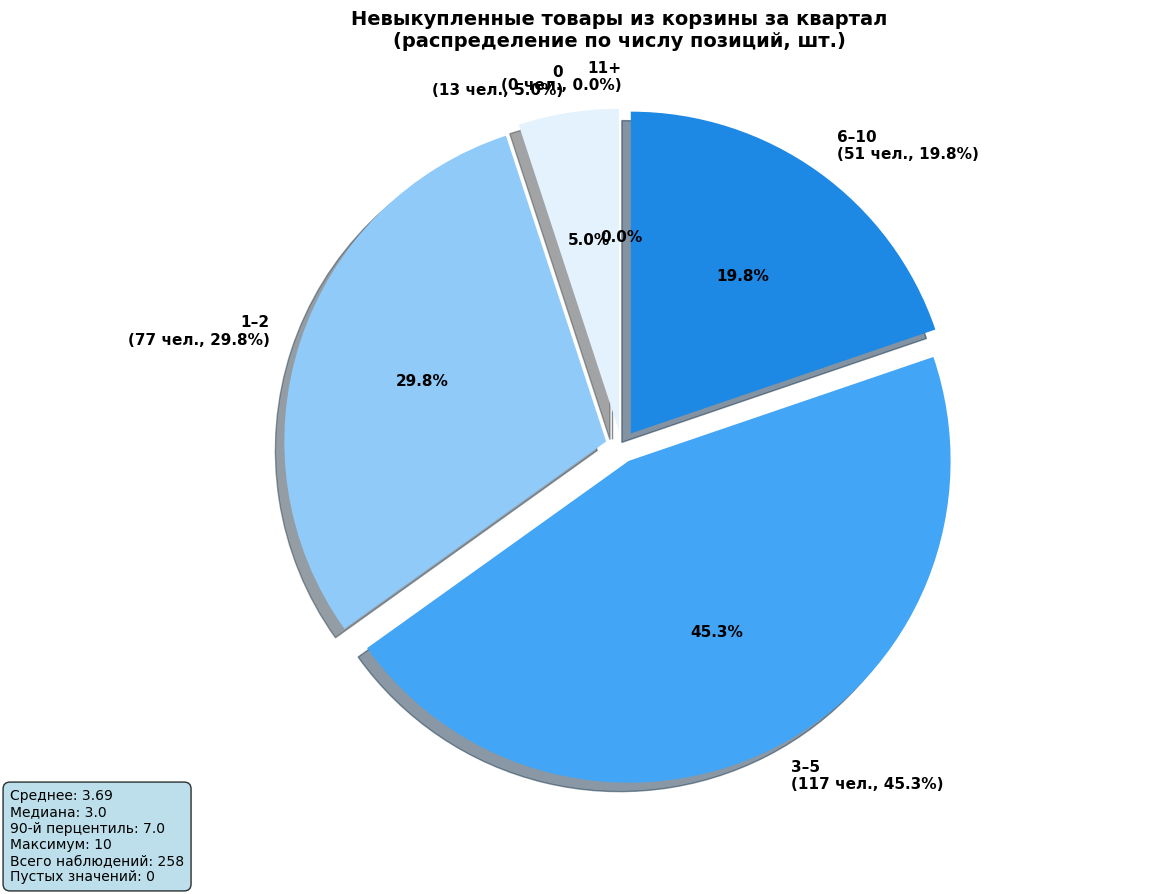

In [87]:
col = "неоплаченные_продукты_штук_квартал"
x = pd.to_numeric(premium[col], errors="coerce").copy()
x = x.clip(lower = 0)

def categorize_unpurchased(n):
    if n == 0:
        return "0"
    elif n <= 2:
        return "1–2"
    elif n <= 5:
        return "3–5"
    elif n <= 10:
        return "6–10"
    else:
        return "11+"

premium["unpaid_category"] = x.apply(categorize_unpurchased)

order = ["0", "1–2", "3–5", "6–10", "11+"]
counts = premium["unpaid_category"].value_counts().reindex(order, fill_value=0)

avg = x.mean()
median = x.median()
p90 = x.quantile(0.90)
maxv = x.max()
n_total = len(x)
n_na = premium[col].isna().sum()

plt.figure(figsize = (12, 9))

colors = ["#E3F2FD", "#90CAF9", "#42A5F5", "#1E88E5", "#0D47A1"]
labels = [
    f"{cat}\n({cnt} чел., {cnt/len(premium)*100:.1f}%)"
    for cat, cnt in counts.items()
]

plt.pie(
    counts.values,
    labels = labels,
    colors = colors,
    autopct = "%1.1f%%",
    startangle = 90,
    explode = (0.05, 0.05, 0.05, 0.05, 0.05),
    shadow = True,
    textprops = {"fontsize": 11, "fontweight": "bold"}
)

plt.title(
    "Невыкупленные товары из корзины за квартал\n(распределение по числу позиций, шт.)",
    fontsize = 14, fontweight = "bold", pad = 20
)

stats_text = (
    f"Среднее: {avg:.2f}\n"
    f"Медиана: {median:.1f}\n"
    f"90-й перцентиль: {p90:.1f}\n"
    f"Максимум: {maxv:.0f}\n"
    f"Всего наблюдений: {n_total}\n"
    f"Пустых значений: {n_na}"
)

plt.text(
    -1.9, -1.35, stats_text,
    fontsize=10,
    bbox = dict(boxstyle = "round,pad=0.5", facecolor = "lightblue", alpha = 0.8)
)

plt.axis("equal")
plt.tight_layout()
plt.show()


У большинства премиальных пользователей много невыкупленных товаров в карзине за последние месяцы. Вероятно, стоит продумать методы напоминаний и поощрений покупки невыкупленных товаров.

## Итоговые выводы

### Задача

Была поставлена **задача** построения модели для **предсказания покупательской активности** клиентов и выяснения **способов их удержания**.

### Подготовка данных

Были получены и подготовлены 4 файла с данными:
- унификация называний признаков
- фильтрация дубликатов
- преобразования типов данных
- обработаны пропуски
- исправлены описки
- расспотрена описательная статистика
- построены графики частот для количественных и качественных признаков
- обхеденены наборы данных из 4 файлов

### Поиск модели

Для поиска модели были **опробованы 4 алгоритма** классификации **с разными наборами** целесообразных **гиперпараметров** случайным образом.

### Лучшая модель классификации

В качестве **лучшей модели предсказания активности** клиента была получена модель **ближайших соседей с точностью** ROC AUC близкой к **идеальной**.

### **Идеи удержания клиентов**

В качестве основного для бизнеса был выделен **"премиальный" сегмент клиентов** с относительно высокой прибылью для бизнеса (~ 19% от всех пользователей), **теряющих интерес** к сервису.

**Замечания для маркетологов**:

Динамика выручки:
- Стабильно высокая выручка от премиальных пользователей в сегментах кухонной посуды и косметики и аксессуаров
- За последние два месяца упала выручка в сегментах техники для красоты и здоровья, товаров для детей
- За последние 2 месяца повысилась выручка в сегментах мелкой бытовой техники и электроники, домашнего текстиля

Категории товаров в премиальном сегменте пользователей приносящие наибольшую прибыль компании:
1) Косметика и аксессуары
2) Товары для детей и дома
3) Техника для красоты и здоровья

**Рекомендации**:
- **Можно продумать специальное предложение подписки на сервис премиальным клиентам для повышения их удержания**, т.к. такой шаг будет актуален для большинства премиальных клиентов в силу отсутствия у них подписки.
- Предоставить **временную повышенную скидку** на все товары **для пользователей**, которые **покупают меньше 20% товаров со скидкой** с целью **возвращения их интереса к сервису**
- Возможно, стоит реже показывать премиальным пользователям маркетинговые сообщения т.к. они им надоедают. Стоит провести дополнительное исследование этой гипотезы.
- Стоит продумать методы напоминаний и поощрений покупки невыкупленных товаров.
- Детальнее продумать маркетинговую стратегию для "премиального" сегмента пользователей